# Notebook for replicating figures from Drake et al. 2019 on the Abyssal Circulation

Note: may need to `build IJulia` in the anaconda environment that jupyter lab is launched from and `build NetCDF` before `using` it.

In [5]:
add_gsw = false
build_packages = false

if build_packages
    using Pkg
    Pkg.build("IJulia")
    Pkg.build("NetCDF")
end

dir = "../pgcm/"
using Statistics
using NetCDF
using NaNMath; nm=NaNMath
using PyCall
using PyPlot
using Interpolations
using MAT

if add_gsw
    using Conda
    Conda.add("gsw")
end
gsw = pyimport("gsw");

nanmean(a) = mean(filter(!isnan,a));
nanmean(a, dims) = mapslices(nanmean, a, dims = dims);

dpi = 75;

In [6]:
N = sqrt(1.5)*1.e-3
#layer_scale = mean(exp.(-((2500:100:5000)+z0)/1000)) # average of exponential decay of abyssal layer
H = 2500.
Htop = 2500.
B = 2.e-11
L = 6e6
Uscale = (N^2)*(H^2)/(B*L^2)*1e3
Wscale = (N^2)*(H^3)/(B*L^3)*1e3
Tscale = (N^2)*(H^3)/(B*L)*1.e-6
kscale = 5.e-2;

dt = 2.e-5
dt_recip = Int(round(dt^-1))

#topo_col = (21./255.,30./255.,68./255.)
topo_col = (0.75,0.75,0.80);

PyCall.PyDict(matplotlib."rcParams")["font.size"]=15;


# Numerical model configuration

In [ ]:

filepath = "../data/raw/woce_global_hydrographic_climatology/wghc_params.nc"
depth = -ncread(filepath,"ZAX")[:]
depth = reshape(depth,(1,1,size(depth)[1]))
gamman = ncread(filepath,"GAMMAN")[:,:,:];

gamman[gamman .<= 0.] .= NaN
lon = ncread(filepath,"LON")
lon = reshape(lon,(size(lon)[1],1,1))
lat = ncread(filepath,"LAT");
lat = reshape(lat,(1,size(lat)[1],1));

N2 = -(gamman[:,:,2:end].-gamman[:,:,1:end-1])./(depth[:,:,2:end].-depth[:,:,1:end-1])*9.81/(1020.);

depth_N2 = (depth[:,:,2:end].+depth[:,:,1:end-1])/2.;

lat_min = -55; lat_max = -45; lon_min = 175; lon_max = 245;

mm,lat_min_idx = findmin(abs.(lat[1,:,1] .- lat_min))
mm,lat_max_idx = findmin(abs.(lat[1,:,1] .- lat_max))
mm,lon_min_idx = findmin(abs.(lon[:,1,1] .- lon_min))
mm,lon_max_idx = findmin(abs.(lon[:,1,1] .- lon_max))

N2av = nanmean(N2[lon_min_idx:lon_max_idx,lat_min_idx:lat_max_idx,:], [1,2]);

In [ ]:
#### Fig 2

figure(figsize=(13,8))

cmap=get_cmap("RdBu_r")
vcmap=get_cmap("viridis_r")
expname = "ridge-0.8_del-0.4";

include(string(dir,expname,"/runs/equil/kernel.jl"));

lati = 150 # latitude of transect
loni = 50 # longitude of transect

m = load(string(dir,expname,"/runs/equil")) # Model setup

hc = [m.hc[1,j,i] for k in 1:length(m.sf), j in 1:length(m.yc), i in 1:length(m.xc)];
kridgeav = sum((m.kfs.*ones(size(m.hc))).*(m.hc.*m.ds.*ones(size(hc)))*m.dx*m.dy)./sum((m.hc.*m.ds.*ones(size(hc)))*m.dx*m.dy)

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

dep = -((sc).*hc)*H .+Htop

ax1 = subplot2grid((8, 8), (0, 0), rowspan = 8, colspan=4)
cp = pcolor(xc[1,:,:]*L*1e-3,yc[1,:,:]*L*1.e-3,hc[1,:,:]*H .+Htop,cmap=vcmap)
colorbar(label="depth [m]")
clim([Htop.+H, Htop])
fill_between(xc[1,50,:]*L*1.e-3, yc[1,1,:]*L*1.e-3, yc[1,50,:]*L*1.e-3, color="w",alpha=0.5)
ylabel("meridional distance [km]")
xlabel("zonal distance [km]")
annotate(s="a)",xy=(0.01,0.965),xycoords="axes fraction",fontsize=16)

plot(xc[1,50,:]*L*1.e-3,yc[1,50,:]*L*1.e-3,"-",lw=3,color="k")
annotate(s="Buoyancy restoring region,\nwhere bottom waters form",xy=(0.14,0.093),xycoords="axes fraction",color="k",fontsize=14)

fill_between([xc[1,1,27],xc[1,1,73]]*L*1.e-3,[yc[1,100,1],yc[1,100,1]]*L*1.e-3,[yc[1,150,1],yc[1,150,1]]*L*1.e-3,color="w",alpha=0.3)
plot(xc[1,100:150,27]*L*1.e-3,yc[1,100:150,27]*L*1.e-3,"-",lw=2,color="k")
plot(xc[1,100,27:73]*L*1.e-3,yc[1,100,27:73]*L*1.e-3,"-",lw=2,color="k")
plot(xc[1,100:150,73]*L*1.e-3,yc[1,100:150,73]*L*1.e-3,"-",lw=2,color="k")
plot(xc[1,150,27:73]*L*1.e-3,yc[1,150,27:73]*L*1.e-3,"-",lw=2,color="k")
annotate(s="Watermass\ntransformation\nanalysis region",xy=(0.30,0.57),xycoords="axes fraction",color="k",fontsize=14)

ax2 = subplot2grid((8, 8), (0, 4), rowspan = 3, colspan=4)
ax = gca()
ax.set_facecolor(topo_col)
cp = pcolor(xc[2:end,lati,:]*L*1.e-3,-(m.sf.*m.hc)[:,lati,:]*H .+Htop,(m.kfs.*ones(size(m.hc)))[:,lati,:]*kscale,
    cmap=get_cmap("viridis"), norm=matplotlib[:colors][:LogNorm](vmin=5e-5, vmax=5e-3))
ylabel("depth [m]")
ax2.xaxis.tick_top()
ax2.set_xlabel("zonal distance [km]")
ax2.xaxis.set_label_position("top")
cb = colorbar(label=L"vertical diffusivity [m$^{2}$/s]",orientation="horizontal",
    pad=0.025, ticks =[5e-5,5e-4,5e-3], format="%.0e")
ylim([H .+ Htop, Htop.+100])
annotate(s="b)",xy=(0.0085,0.78),xycoords="axes fraction",fontsize=16)

ax3 = subplot2grid((8, 8), (3, 4), rowspan = 5, colspan=4)
z0=-Htop
plot(N^2*exp.(-(-depth[1,1,:] .+z0)/500)*1e6,-depth[1,1,:],"r--",lw=2.,label=L"$\delta=500\; m$",alpha=0.5)
plot(N^2*exp.(-(-depth[1,1,:] .+z0)/1000)*1e6,-depth[1,1,:],"r--",lw=2.5,label=L"$\delta=1000\; m$")
plot(N^2*exp.(-(-depth[1,1,:] .+z0)/2000)*1e6,-depth[1,1,:],"r--",lw=2.,label=L"$\delta=2000\; m$",alpha=0.5)
plot(N^2*exp.(-(-depth[1,1,:] .+z0)/1e20)*1e6,-depth[1,1,:],"r-",lw=2.5,label=L"$N^{2}=$constant")
plot(N2av[1,1,:]*1.e6,-depth_N2[1,1,:],"k",lw=2.5, label="observed")
ylim([Htop+H, Htop])
xlim([-5e-10*1e6, 1.75e-6*1e6])
xlabel(L"stratification $[10^{-6} \, $s$^{-2}]$")
ylabel("depth [m]")
legend(loc=4)
annotate(s="c)",xy=(0.01,0.94),xycoords="axes fraction",fontsize=16)

tight_layout()

savefig(string("../figures/model_setup.png"),dpi=dpi,bbox_inches="tight")

# Equilibrium circulation

In [ ]:
expname = "ridge-0.8_del-0.4";
nIter = dt_recip*50

m = load(string(dir,expname,"/runs/equil")) # Model setup
s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

# Interpolate all fields to cell centers before performing operations
usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

# Calculate vertical velocity from sigma coordinate velocities
uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc;

dep = -((sc).*hc)*H .+Htop
Nsq = dscc(m,s.bc,0.)./m.hc;

In [ ]:
figure(figsize=(16,6))
xy = (0.015,0.03)

lati = 150
subplot(2,3,1)
ax = gca()
ax.set_facecolor(topo_col)
pcolor(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],Uscale*uxc[:,lati,:],cmap=get_cmap("RdBu_r"))
colorbar(ticks=[-1,0,1])
clim([-1,1])
cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],s.bc[:,lati,:],levels=-1.075:0.1:0, colors="k",linestyles="solid")
xlabel("zonal distance (km)")
ylabel("depth (m)")
title("zonal velocity (mm/s)",fontsize=16)
xlim([0,L*1e-3])
ylim([H+Htop,Htop])
annotate(s="a)",xy=xy,xycoords="axes fraction",fontsize=16)


subplot(2,3,2)
ax = gca()
ax.set_facecolor(topo_col)
pcolor(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],Uscale*uyc[:,lati,:],cmap=get_cmap("RdBu_r"))
colorbar(ticks=[-1,0,1])
clim([-1,1])
cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],s.bc[:,lati,:],levels=-1.075:0.1:0, colors="k",linestyles="solid")
xlabel("zonal distance (km)")
ylabel("depth (m)")
title("meridional velocity (mm/s)",fontsize=16)
xlim([0,L*1e-3])
ylim([H+Htop,Htop])
annotate(s="b)",xy=xy,xycoords="axes fraction",fontsize=16)

subplot(2,3,3)
ax = gca()
ax.set_facecolor(topo_col)
pcolor(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],Wscale*uzc[:,lati,:],cmap=get_cmap("RdBu_r"))
colorbar(ticks=[-0.001,0,0.001])
clim([-0.001,0.001])
cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],s.bc[:,lati,:],levels=-1.075:0.1:0, colors="k",linestyles="solid")
xlabel("zonal distance (km)")
ylabel("depth (m)")
title("vertical velocity (mm/s)",fontsize=16)
xlim([0,L*1e-3])
ylim([H+Htop,Htop])
annotate(s="c)",xy=xy,xycoords="axes fraction",fontsize=16)

lati = 100

subplot(2,3,4)
ax = gca()
ax.set_facecolor(topo_col)
pcolor(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],Uscale*uxc[:,lati,:],cmap=get_cmap("RdBu_r"))
colorbar(ticks=[-1,0,1])
clim([-1,1])
cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],s.bc[:,lati,:],levels=-1.075:0.1:0, colors="k",linestyles="solid")
xlabel("zonal distance (km)")
ylabel("depth (m)")
title("zonal velocity (mm/s)",fontsize=16)
xlim([0,L*1e-3])
ylim([H+Htop,Htop])
annotate(s="d)",xy=xy,xycoords="axes fraction",fontsize=16)


subplot(2,3,5)
ax = gca()
ax.set_facecolor(topo_col)
pcolor(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],Uscale*uyc[:,lati,:],cmap=get_cmap("RdBu_r"))
colorbar(ticks=[-1,0,1])
clim([-1,1])
cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],s.bc[:,lati,:],levels=-1.075:0.1:0, colors="k",linestyles="solid")
xlabel("zonal distance (km)")
ylabel("depth (m)")
title("meridional velocity (mm/s)",fontsize=16)
xlim([0,L*1e-3])
ylim([H+Htop,Htop])
annotate(s="e)",xy=xy,xycoords="axes fraction",fontsize=16)

subplot(2,3,6)
ax = gca()
ax.set_facecolor(topo_col)
cp = pcolor(L*1e-3*xc[:,lati,:],dep[:,lati,:],Wscale*uzc[:,lati,:],cmap=cmap)
colorbar(ticks=[-0.001,0,0.001])
clim([-0.001,0.001])
cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],s.bc[:,lati,:],levels=-1.075:0.1:0, colors="k",linestyles="solid")
xlabel("zonal distance (km)")
ylabel("depth (m)")
title("vertical velocity (mm/s)",fontsize=16)
xlim([0,L*1e-3])
ylim([H+Htop,Htop])
annotate(s="f)",xy=xy,xycoords="axes fraction",fontsize=16)

tight_layout(h_pad = 0.3)

annotate(s="NH sections",xy=(0.001,0.955),xycoords="figure fraction",color=(0.15,0.15,0.35),fontsize=18)
annotate(s="EQ sections",xy=(0.001,0.47),xycoords="figure fraction",color=(0.15,0.15,0.35),fontsize=18)

savefig(string("../figures/velocity.png"),dpi=dpi,bbox_inches="tight")

# Equilibrium meridional overturning streamfunctions

In [ ]:
expname = "ridge-0.8_del-0.4";
nIter = dt_recip*50

blevel = [-0.824,-0.624,-0.424,-0.224]

nf = 150
del = 1.

## Model Parameters
r = 0.1; # friction coefficient
a = 0.2; # aspect ratio (?)

# Plotting Parameters
lati = 150 # latitude of transect
loni = 25
lonridge = 50

cmap=get_cmap("RdBu_r")
PyCall.PyDict(matplotlib."rcParams")["figure.figsize"] = 10, 5
PyCall.PyDict(matplotlib."rcParams")["contour.negative_linestyle"] = "solid"

#------------------------  Load  Model data  ------------------------------

include(string(dir,expname,"/runs/equil/kernel.jl"))
m = load(string(dir,expname,"/runs/equil")) # Model setup
s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

tht = -atan.(m.hxc)

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

# Interpolate all fields to cell centers before performing operations
usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

# Calculate vertical velocity from sigma coordinate velocities
uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

dep = -((sc).*hc)*H .+Htop

b0 = m.bic

#------------------------  Calculate Psi(y,z) ------------------------------
mins = -1.
dsf = abs(mins/nf)
sf = reshape(mins+dsf/2:dsf:0-dsf/2, (nf, 1, 1))
scb = reshape(mins:dsf:0, (nf+1, 1, 1))

bf = del*(exp.(sf/del).-1)
dbf = bf[2:end]-bf[1:end-1]
bc = del*(exp.(scb/del).-1)
dbc = bc[2:end]-bc[1:end-1]

itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear())), NaN);
bcf = itp(sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:])

itp = extrapolate(interpolate((m.sc[:,1,1], m.yf[1,:,1], m.xc[1,1,:]), uy, Gridded(Linear())), NaN);
uyf = itp(sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]);

psi = zeros(nf, m.ny-1)
zf = zeros(nf, m.ny-1)
bpsi = zeros(nf, m.ny-1)
for i in 1:nf
    print(string(" ",i))
    idx = bcf.<bc[i]
    psi[i,:] = -sum(idx.*uyf.*m.hfy, dims=(1,3))*m.dy*dsf
    idx = bc[i] .< bcf .< bc[i+1]
    zf[i,:] = sum(idx.*sf.*m.hfy, dims=(1, 3))./sum(idx, dims=(1, 3))
    bpsi[i,:] .= (bc[i]+bc[i+1])/2.
end
zf[isnan.(zf)] .= -1.
zf=sort(zf, dims=1);

yp,bp = 
[m.yf[i] for k in 1:length(bf), i in 1:length(m.yf)],
[bf[k] for k in 1:length(bf), j in 1:length(m.yf)];

ypz,zpz = 
[m.yf[i] for k in 1:length(zf[:,1]), i in 1:length(m.yf)],
[zf[k,j] for k in 1:length(zf[:,1]), j in 1:length(m.yf)];

hpz = [m.hfy[1,j,50] for k in 1:nf, j in 1:length(m.yf)];
bpsi[zpz.<-hpz] .= NaN

y_yz = copy(ypz)
z_yz = copy(zpz)
psi_yz = copy(psi)

#------------------------  Calculate Psi(X,Z) ------------------------------

mins = -1.
dsf = abs(mins/nf)
sf = reshape(mins+dsf/2:dsf:0-dsf/2, (nf, 1, 1))
scb = reshape(mins:dsf:0, (nf+1, 1, 1))

bf = del*(exp.(sf/del).-1)
dbf = bf[2:end]-bf[1:end-1]
bc = del*(exp.(scb/del).-1)
dbc = bc[2:end]-bc[1:end-1]

itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear())), NaN);
bcf = itp(sf[:,1,1], m.yc[1,:,1], m.xf[1,1,:])

itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xf[1,1,:]), ux, Gridded(Linear())), NaN);
uxf = itp(sf[:,1,1], m.yc[1,:,1], m.xf[1,1,:]);

psi = zeros(nf, m.nx-1)
zf = zeros(nf, m.nx-1)
bpsi = zeros(nf, m.nx-1)
for i in 1:nf
    print(string(" ",i))
    idx = bcf.<bc[i]
    psi[i,:] = -sum(idx.*uxf.*m.hfx, dims=(1,2))*m.dx*dsf
    idx = bc[i] .< bcf .< bc[i+1]
    zf[i,:] = sum(idx.*sf.*m.hfx, dims=(1, 2))./sum(idx, dims=(1, 2))
    bpsi[i,:] .= (bc[i]+bc[i+1])/2.
end
zf[isnan.(zf)] .= -1.
zf=sort(zf, dims=1);

xp,bp = 
[m.xf[i] for k in 1:length(bf), i in 1:length(m.xf)],
[bf[k] for k in 1:length(bf), i in 1:length(m.xf)];

xpz,zpz = 
[m.xf[i] for k in 1:length(zf[:,1]), i in 1:length(m.xf)],
[zf[k,i] for k in 1:length(zf[:,1]), i in 1:length(m.xf)];

hpz = [m.hfx[1,100,i] for k in 1:nf, i in 1:length(m.xf)];
bpsi[zpz.<-hpz] .= NaN

psi_xz = copy(psi)
x_xz = copy(xpz)
z_xz = copy(zpz)


#------------------------  Calculate Psi(X,Y) ------------------------------

U,V = dropdims(sum(uxc.*m.ds.*m.hc, dims=1), dims=1), dropdims(sum(uyc.*m.ds.*m.hc, dims=1), dims=1)

psi_xy = cumsum(V, dims=2)*m.dx;



In [ ]:
fig = figure(figsize=(14,9))
gridspec = matplotlib.gridspec
gs = gridspec.GridSpec(
    2, 2,
    width_ratios=[3, 1],
    height_ratios=[1, 2.5]
)

maxT = 2
dT = 0.2
levels = -maxT:dT:maxT

lonridge = 50
loni = 25
latridge = 160
latdeepest = 26

ax1 = subplot(gs[1])
cf = contourf(y_yz*L*1.e-3,z_yz*(-H).+Htop,psi_yz*Tscale,cmap=cmap,levels=levels,extend="both")
ct = contour(yc[:,:,loni]*L*1.e-3,(sc.*hc)[:,:,loni]*(-H).+Htop,s.bc[:,:,loni],5,colors="k",linestyles="solid",linewidths=1)
fill_between(yc[1,:,loni]*L*1.e-3,zeros(size(hc[1,:,loni])).+6000.,-hc[1,:,loni]*(-H).+Htop,color=topo_col)
plot(yc[1,:,lonridge]*L*1.e-3,-hc[1,:,lonridge]*(-H).+Htop,color="brown",lw=3.)
xlim([-L*1.e-3*0.98,L*1.e-3*0.98])
yticks([5000,4000,3000])
ylim([(H+Htop)*0.98,Htop])
ylabel("depth [m]")
title("meridional overturning")
annotate(s="a)",xy=(0.0075,0.045),xycoords="axes fraction",fontsize=18)

ax2 = fig[:add_axes]([0.755,0.84,0.22,0.04])
colorbar(cf,cax=ax2,ticks=-maxT:dT*5:maxT,orientation="horizontal",label="streamfunction [Sv]")

ax3 = subplot(gs[3])
ax = gca()
ax."set_facecolor"(topo_col)
psi_xy[m.hc[1,:,:].<0.196] .= NaN
contourf(yc[1,:,:]*L*1.e-3,xc[1,:,:]*L*1.e-3,psi_xy*Tscale,cmap=cmap,levels=levels)
ct = contour(yc[1,:,:]*L*1.e-3,xc[1,:,:]*L*1.e-3,hc[1,:,:]*H.+Htop,levels=[3000,4000],colors="k",linestyles="solid",linewidths=3)
clabel(ct, inline=true, fontsize=12)
plot(yc[1,latridge,:]*L*1.e-3,xc[1,latridge,:]*L*1.e-3,color="midnightblue",lw=3.,linestyle="--",alpha=0.6)
plot(yc[1,:,lonridge]*L*1.e-3,xc[1,:,lonridge]*L*1.e-3,color="brown",lw=3.,linestyle="--",alpha=0.6)
ylim([L*1.e-3*0.98,L*1.e-3*0.02])
xlim([-L*1.e-3*0.98,L*1.e-3*0.98])
xlabel("meridional distance [km]");
ylabel("zonal distance [km]");
title("barotropic circulation")
annotate(s="b)",xy=(0.0075,0.945),xycoords="axes fraction",fontsize=18)

ax4 = subplot(gs[4])
contourf(z_xz*(-H).+Htop,x_xz*L*1.e-3,psi_xz*Tscale,cmap=cmap,levels=levels)
ct = contour((sc.*hc)[:,lati,:]*(-H).+Htop,xc[:,lati,:]*L*1.e-3,s.bc[:,lati,:],5,colors="k",linestyles="solid",linewidths=1)
fill_betweenx(xc[1,latdeepest,:]*L*1.e-3,zeros(size(hc[1,latdeepest,:])).+6000,-hc[1,latdeepest,:]*(-H).+Htop,color=topo_col)
plot(-hc[1,latridge,:]*(-H).+Htop,xc[1,latridge,:]*L*1.e-3,color="midnightblue",lw=3.)
ylim([L*1.e-3*0.98,L*1.e-3*0.02])
yticks([])
xticks([4000,3000])
xlim([(H+Htop)*0.98,Htop])
xlabel("depth [m]")
title("zonal overturning")
annotate(s="c)",xy=(0.02,0.945),xycoords="axes fraction",fontsize=18)

tight_layout()
savefig(string("../figures/streamfunctions.png"),dpi=dpi,bbox_inches="tight")

In [ ]:
figure(figsize=(15,7))
panel_label=["a)","b)","c)","d)"]
xy = (0.01,0.03)

iplot=1
for nIter = [dt_recip*0.1,dt_recip*50]
    expname = "ridge-0.8_del-inf"

    m = load(string(dir,expname,"/runs/equil")) # Model setup
    s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

    ux,uy,us = velocities(m,s.bc);

    xc,yc,sc,hc = 
    [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

    hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
    hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

    us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
    uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
    ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

    # Interpolate all fields to cell centers before performing operations
    usc = (us_temp[1:end-1,:,:] .+ us_temp[2:end,:,:])/2.
    uyc = (uy_temp[:,1:end-1,:] .+ uy_temp[:,2:end,:])/2.
    uxc = (ux_temp[:,:,1:end-1] .+ ux_temp[:,:,2:end])/2.

    # Calculate vertical velocity from sigma coordinate velocities
    uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc;


    file = h5open(@sprintf("%s%s/runs/equil/1d_%010d.h5",dir,expname,nIter), "r")
    bc = read(file, "bc") .-m.bic;

    tht = -atan.(m.hxc)
    r = 0.1; # friction coefficie-atan.(m.hxc)nt
    a = 0.2; # aspect ratio
    # 1D prediction velocities in rotated coordinates
    uxr = r.*tan.(tht).^2. ./ ((r^2 .+ m.yc.^2).*sin.(tht)).*bc
    uyr = (-m.yc.*cos.(tht) ./ r) .*uxr
    uzr = uxr*0.

    ux = uxr.*cos.(tht) .- uzr.*sin.(tht);
    uy = uyr
    uz = uzr.*cos.(tht) .+ uxr.*sin.(tht);

    dep = -((sc).*hc)*H .+Htop
    
    lati = 150

    subplot(2,2,1+(iplot-1)*2)
    ax = gca()
    ax."set_facecolor"(topo_col)
    cp = pcolor(L*1e-3*xc[:,lati,:],dep[:,lati,:],Wscale*uz[:,lati,:],cmap=get_cmap("RdBu_r"))
    colorbar(ticks=[-0.001,0,0.001],label="vertical velocity (mm/s)")
    clim([-0.001,0.001])
    cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],(bc.+m.bic)[:,lati,:],levels=-1.075:0.25:0, colors="k",linestyles="solid")
    xlabel("zonal distance (km)")
    ylabel("depth (m)")
    title(string("1D Emulator ",L"($\hat{t} = $",round(nIter/40000.,digits=1),")"),fontsize=16)
    xlim([0.27,0.73]*L*1e-3)
    ylim([5000,2550])
    annotate(s=panel_label[1+(iplot-1)*2],xy=xy,xycoords="axes fraction",fontsize=16)

    subplot(2,2,2+(iplot-1)*2)
    ax = gca()
    ax."set_facecolor"(topo_col)
    cp = pcolor(L*1e-3*xc[:,lati,:],dep[:,lati,:],Wscale*uzc[:,lati,:],cmap=get_cmap("RdBu_r"))
    colorbar(ticks=[-0.001,0,0.001],label="vertical velocity (mm/s)")
    clim([-0.001,0.001])
    cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],(bc.+m.bic)[:,lati,:],levels=-1.075:0.25:0, colors="grey",linestyles="dashed")
    cp = contour(xc[:,lati,:]*L*1.e-3,dep[:,lati,:],s.bc[:,lati,:],levels=-1.075:0.25:0, colors="k",linestyles="solid")
    xlabel("zonal distance (km)")
    ylabel("depth (m)")
    title(string("3D PGCM ",L"($\hat{t} = $",round(nIter/40000.,digits=1),")"),fontsize=16)
    xlim([0.27,0.73]*L*1e-3)
    ylim([5000,2550])
    annotate(s=panel_label[2+(iplot-1)*2],xy=xy,xycoords="axes fraction",fontsize=16)

    iplot+=1
end
tight_layout()
savefig(string("/nobackup1/hdrake/figures/ch1_manuscript/compare_1d_3d.png"),dpi=dpi,bbox_inches="tight")

# Equilibrium watermass transformations

The total watermass transformations are given by
\begin{equation}
T 
= \frac{\partial}{\partial \gamma} \int_{\gamma'>\gamma} \nabla \cdot (\kappa \nabla \gamma') \; dV
\approx \frac{\partial}{\partial \gamma} \int_{\gamma'>\gamma} \partial_{z} (\kappa \partial_{z} \gamma') \; dV
\end{equation}

In [ ]:
file = matopen("../data/raw/buoyancy_flux/4Henri_with_bkg_K.mat")
names(file)
# This gives an error, but it seems that it can be ignored and otherwise works as intentded...

In [ ]:

names(file);
varnames = file.varnames;

rho0 = 1020.
g = 9.81

lon = -180.:1.:179.
lat = -74.:1.:63.
dA = read(file, "CA");
pres = read(file, "P");

dep = read(file, "bathy");
Gamma = read(file, "Gamma");

gamma = read(file, "D");

pres_f = read(file, "P1");
dpres_c = pres_f[2:end] - pres_f[1:end-1]
wb_f = read(file, "WB"); # wb_f = -kappa_f.*N2_f
N2_f = read(file, "N2");
gamma_f = read(file, "D1");
kappa_f = read(file, "Kv"); # kappa_f = -wb_f./N2_f
wbbg_f = read(file, "bgflux");

interp_f_to_c(field_f) = (field_f[:,:,2:end].+field_f[:,:,1:end-1])/2.
divergence(wb_f) = (wb_f[:,:,1:end-1].-wb_f[:,:,2:end])./reshape(dpres_c, (1,1,size(dpres_c)...))

N2_av = nanmean(N2_f,[1,2])
N2_f[isnan.(N2_f)] .= 0.
kappa_f[isnan.(kappa_f)] .= 0.
kappa_f[kappa_f.>1.e-1] .= 1.e-1
wb_f[isnan.(wb_f)] .= 0.

dV = reshape(dpres_c, (1,1,size(dpres_c)...)).*reshape(dA, (size(dA)...,1))

pres_c = (pres_f[1:end-1] .+ pres_f[2:end])/2.
gamma_c = gamma[:,:,2:end-1]

fluxdiv_c = divergence(wb_f) .*(-rho0/g);

find_zero_index(array,j,i) = findmax(array[j,i,:].==0.)[2]
bbl_idx = [
    find_zero_index(fluxdiv_c,j,i).-1==k
    for j=1:size(fluxdiv_c,1), i=1:size(fluxdiv_c,2), k=1:size(fluxdiv_c,3)
    ]

fluxdiv_varN_c = -interp_f_to_c(kappa_f).*divergence(N2_f) .*(-rho0/g);
fluxdiv_vark_c = -interp_f_to_c(N2_f).*divergence(kappa_f) .*(-rho0/g);

fluxdiv_bbl_c = copy(fluxdiv_c); fluxdiv_bbl_c[.~bbl_idx] .= 0.
fluxdiv_sml_c = copy(fluxdiv_c); fluxdiv_sml_c[bbl_idx] .= 0.

dgamma_lev = 0.02
gamma_lev = 28.0-dgamma_lev:dgamma_lev:28.3+dgamma_lev
intfluxdiv_c = zeros(size(gamma_lev));

fluxdivs = [fluxdiv_c,fluxdiv_bbl_c,fluxdiv_sml_c]
colors = ["k","r","b"]

lat_2d = repeat(lat,1,length(lon))
lon_2d = permutedims(repeat(lon, 1, length(lat)), [2,1])

A_coords = [-26,-40,25,30]
I_coords = [55,-25,25,30]
P_coords = [-126,-40,25,30]

z_3d = permutedims(repeat(-pres_c,1,size(fluxdiv_c,1),size(fluxdiv_c,2)), [2,3,1]);

In [ ]:
dir = "../pgcm/"
expname = "ridge-0.8_del-0.4"

include(string(dir,expname,"/runs/equil/kernel.jl"))
using PyPlot
using Interpolations

nIter = dt_recip*50

nf = 40
del = 3

figure(figsize=(16,8))

short_name = L"$\hat{\delta} = 0.4$"

#------------------------  Load 3d Model data  ------------------------------

m = load(string(dir,expname,"/runs/equil")) # Model setup
s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

# Interpolate all fields to cell centers before performing operations
usc = (us_temp[1:end-1,:,:] .+ us_temp[2:end,:,:])/2.
uyc = (uy_temp[:,1:end-1,:] .+ uy_temp[:,2:end,:])/2.
uxc = (ux_temp[:,:,1:end-1] .+ ux_temp[:,:,2:end])/2.

# Calculate vertical velocity from sigma coordinate velocities
uzc = usc.*hc .+ sc.*hxc.*uxc .+ sc.*hyc.*uyc

# Restoring
Dr = -m.cc.*(s.bc-m.bic)

# Advective fluxes
# get velocities
Ux, Uy, Us = velocities(m,s.bc)
# calculate advective fluxes
hFx = m.hfx.*Ux.*ixcf(m,s.bc)
hFy = m.hfy.*Uy.*iycf(m,s.bc)
hFs = m.hc.*Us.*iscf(m,s.bc)

# Advective flux divergence
Du = zeros(size(s.bc))
Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

# Advective flux divergences
Dux = zeros(size(s.bc))
Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

Duy = zeros(size(s.bc))
Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

Dus = zeros(size(s.bc))
Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

# Buoyancy tendency 
s1 = load(string(dir,expname,"/runs/equil"),nIter+5000); # Model state
dbdt = (s1.bc .- s.bc) ./ (m.dt*4000.)

# Diagnose exact diffusive flux divergence as residual of other explicit terms
Dk = dbdt .- (Du .+ Dr)

sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);

x_fy,y_fy = 
[m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
[m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);

###############    Water mass transformation     ##################
mins = -1.1
dsf = round(abs(mins/nf),digits=5)
sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

bf = del*(exp.(sf/del) .-1.)
dbf = bf[2:end]-bf[1:end-1]
bc = del*(exp.(scb/del) .-1.)
dbc = bc[2:end]-bc[1:end-1]

itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear())), NaN);
bcf = itp(sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:])

zc = zeros(nf)
for i in 1:nf
    idx = bf[i] .< bcf .< bf[i+1]
    zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
end
zc[isnan.(zc)] .= -1.

########################################
zref = vcat(copy(zc),[0])
bref = vcat(copy(bc)[:,1,1],[0])
nref = length(bref)
intD = zeros(size(bref))

BBLmask = Dk.>0.
for i=1:m.nx
    for j=1:m.ny
        BBLmask[findmin(BBLmask[:,j,i])[2]:20,j,i] .= 0.
    end
end

labels = [
"Total",
"BBL",
"SML",
]

flux_list = [
Dk,
Dk,
Dk,
]

mask_list = [
trues(size(Dk)),
BBLmask,
.~BBLmask
]

colors = [
"k",
"r",
"b",
]

linestyles = [
"-",
"-",
"-",
];

In [ ]:
fig = figure(figsize=(15,8.5))
PyCall.PyDict(matplotlib."rcParams")["font.size"]=14;

ax1 = subplot2grid((4, 4), (0, 0), colspan=1, rowspan=2)
ax2 = subplot2grid((4, 4), (0, 1), colspan=1, rowspan=2)
ax3 = subplot2grid((4, 4), (0, 2), colspan=1, rowspan=2)
ax4 = subplot2grid((4, 4), (0, 3), colspan=1, rowspan=2)
ax5 = subplot2grid((4, 4), (2, 0), colspan=1, rowspan=2)
ax6 = subplot2grid((4, 4), (2, 1), colspan=3, rowspan=2)

ax = ax1
for flux_idx = 1:length(flux_list)
    # Transformations in 3D model
    tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

    intD = zeros(size(bref))
    for i=1:1:nref
        intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& sim_ridge_mask])
    end
    T = diff(intD)./diff(bref) #*Tscale
    T[isnan.(T)] .= 0

    ax.set_title("Simulated Ocean ridge",fontsize=16)
    ax.plot(T*Tscale,0.5*(zref[1:end-1]+zref[2:end])*(-H) .+ Htop,color=colors[flux_idx],linestyle=linestyles[flux_idx])
    ax.set_xlim([-3.,3.])
    ax.set_xticks([-3,-2,-1,0,1,2,3])
    ax.set_ylim([5000,2500])
    ax.set_ylabel("depth [m]")
    ax.set_xlabel("transformation rate [Sv]");

    ax.grid(true);
end
ax.annotate(s="a)",xy=(0.02,0.912),xycoords="axes fraction",fontsize=18)

panel_label = ["b)","c)","d)"]
coord_labels = ["Pacific Ocean ridge","Atlantic Ocean ridge", "Indian Ocean ridge"]
coords_list = [P_coords, A_coords, I_coords]
mask_depth_list = [3500,3900,4500]
axes = [ax2,ax3,ax4]
for f=1:length(fluxdivs)
    coord_idx=1
    for coords=coords_list
        ridge_mask = (
            (lon_2d.>coords[1]) .&
            (lat_2d.>coords[2]) .&
            (lon_2d.<coords[1]+coords[3]) .&
            (lat_2d.<coords[2]+coords[4])
        )
        
        ridge_mask_3d = repeat(ridge_mask,1,1,1)
        
        fluxdiv = fluxdivs[f]

        # Calculate WMT from buoyancy flux divergence
        for i=1:length(gamma_lev)
            idx = (gamma_c.>gamma_lev[i]) .& ridge_mask
            intfluxdiv_c[i] = sum((fluxdiv.*dV)[idx])
        end
        gamma_lev_f = (gamma_lev[1:end-1] .+ gamma_lev[2:end]) ./2.
        T = (intfluxdiv_c[1:end-1] .- intfluxdiv_c[2:end]) ./dgamma_lev;
        
        # Find depth of mean buoyancy surface
        z_gamma_lev = zeros(length(gamma_lev))
        for i in 1:length(gamma_lev)
            idx = gamma_lev[i]-dgamma_lev/2. .< gamma_c .< gamma_lev[i]+dgamma_lev/2.
            z_gamma_lev[i] = sum(idx.*z_3d.*ridge_mask_3d)./sum(idx.*ridge_mask_3d)
        end
        z_gamma_lev[isnan.(z_gamma_lev)] .= -5010.
        
        z_gamma_f = (z_gamma_lev[1:end-1] .+ z_gamma_lev[2:end])/2.
        
        ax = axes[coord_idx]
        
        # Plot WMT
        ax.plot(T*1.e-6,-z_gamma_f,color=colors[f],label=labels[f])
        ax.set_title(coord_labels[coord_idx],fontsize=16)
        ax.set_ylim([5000,2500])
        ax.set_xlim([-3.,3.])
        ax.set_xticks([-3,-2,-1,0,1,2,3])
        ax.set_ylabel("")
        ax.set_yticklabels([])
        ax.set_xlabel("transformation rate [Sv]")
        ax.grid(true)
        ax.fill_between([-3,3],[5000,5000],[mask_depth_list[coord_idx],mask_depth_list[coord_idx]],alpha=1.0,facecolor=topo_col)
        if f==1; ax.annotate(s=panel_label[coord_idx],xy=(0.02,0.912),xycoords="axes fraction",fontsize=18); end;
        if coord_idx==3; ax.legend(loc="lower left", fontsize = 14); end;
        coord_idx+=1
    end
end

ax = ax5
ax.set_facecolor(topo_col)

# Interpolate depth onto z-grid
knots = (m.sc[:],m.yc[:],m.xc[:]);
itp_Dk = extrapolate(interpolate(knots, Dk, Gridded(Linear())), NaN);

Dk_cart = zeros(size(Dk))

for i=1:m.nx
    for j=1:m.ny
        for k=1:m.ns
            if -m.sc[k]<m.hc[1,j,i]
                Dk_cart[k,j,i] = itp_Dk(m.sc[k]./m.hc[1,j,i],m.yc[j],m.xc[i])
            else
                Dk_cart[k,j,i] = NaN
            end
        end
    end
end

pc = ax.pcolor(xc[1,:,:]*L*1.e-3,yc[1,:,:]*L*1.e-3,Dk_cart[m.ns-8,:,:]*(N^2*kscale./H)*1.e13,cmap=get_cmap("RdBu_r"))
pc.set_clim([-5,5])
label_str = string(
    "buoyancy flux convergence\n",
    L"[10$^{-13}$ m s$^{-3}$]"
)

ax.set_ylim([-L*0.15e-3,L*0.65e-3])
ax.set_xlim([L*0.05e-3,L*0.95e-3])
ax.set_xlabel("zonal distance [km]")
ax.set_ylabel("meridional distance [km]")

ax.add_patch(matplotlib.patches.Rectangle((L*0.25e-3, 0.), L*0.5e-3, L*0.5e-3,
            edgecolor="k", linewidth=2.5, alpha=1, facecolor="none"))
ax.annotate(s="e)",xy=(0.025,0.912),xycoords="axes fraction",fontsize=18)

#######
ax = ax6
ax.set_facecolor(topo_col)


dep_idx = 33
fluxdiv_c_slice = copy(fluxdiv_c[:,:,dep_idx])
fluxdiv_c_slice[fluxdiv_c_slice.==0.] .= NaN

pc = ax.pcolor(lon,lat,fluxdiv_c_slice./(rho0/g)*1.e13,cmap=get_cmap("RdBu_r"))
pc.set_clim([-5,5])
label_str = string(
    "buoyancy flux convergence\n",
    L"[10$^{-13}$ m s$^{-3}$]"
)
cb = colorbar(pc,label=label_str)
ax.set_title("")
ax.set_ylim([-50,15])
ax.set_xlim([-140,90])
ax.set_xlabel("longitude [degrees]")
ax.set_ylabel("latitude [degrees]")
ax.annotate(s="f)",xy=(0.0075,0.912),xycoords="axes fraction",fontsize=18)

for coords=coords_list
    ax.add_patch(matplotlib.patches.Rectangle((coords[1], coords[2]), coords[3], coords[4],
            edgecolor="k", linewidth=2.5, alpha=1, facecolor="none"))
end

tight_layout(h_pad=2.0)
annotate(s=string("Buoyancy tendency due to turbulent mixing at ",Int(pres_c[dep_idx])," m"),xy=(0.0652,0.47),xycoords="figure fraction")
savefig(string("../figures/NH_transformations_compare_model_obs.png"),dpi=dpi,bbox_inches="tight")

In [ ]:
dir = "../pgcm/"
expname = "ridge-0.8_del-0.4"

include(string(dir,expname,"/runs/equil/kernel.jl"))

nIter = dt_recip*50

nf = 40
del = 3

figure(figsize=(16,8))

short_name = L"$\hat{\delta} = 0.4$"

#------------------------  Load 3d Model data  ------------------------------

m = load(string(dir,expname,"/runs/equil")) # Model setup
s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

# Interpolate all fields to cell centers before performing operations
usc = (us_temp[1:end-1,:,:] .+ us_temp[2:end,:,:])/2.
uyc = (uy_temp[:,1:end-1,:] .+ uy_temp[:,2:end,:])/2.
uxc = (ux_temp[:,:,1:end-1] .+ ux_temp[:,:,2:end])/2.

# Calculate vertical velocity from sigma coordinate velocities
uzc = usc.*hc .+ sc.*hxc.*uxc .+ sc.*hyc.*uyc

# Restoring
Dr = -m.cc.*(s.bc-m.bic)

# Advective fluxes
# get velocities
Ux, Uy, Us = velocities(m,s.bc)
# calculate advective fluxes
hFx = m.hfx.*Ux.*ixcf(m,s.bc)
hFy = m.hfy.*Uy.*iycf(m,s.bc)
hFs = m.hc.*Us.*iscf(m,s.bc)

# Advective flux divergence
Du = zeros(size(s.bc))
Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

# Advective flux divergences
Dux = zeros(size(s.bc))
Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

Duy = zeros(size(s.bc))
Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

Dus = zeros(size(s.bc))
Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

# Buoyancy tendency
s1 = load(string(dir,expname,"/runs/equil"),nIter+5000); # Model state
dbdt = (s1.bc .- s.bc) ./ (m.dt*5000.)

# Diagnose exact diffusive flux divergence as residual of other explicit terms
Dk = dbdt .- (Du .+ Dr)

# Explicit vertical flux divergence
hFs = -m.kfs./m.hc.*iscf(m,dscc(m,s.bc,0))
Dkz = zeros(size(s.bc))
Dkz[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
Dkz[2:m.ns,:,:] += hFs./(m.hc*m.ds)

sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);
sim_full_ridge_mask = (yc.>=0.) .& (xc.>0.25) .& (xc.<0.75);

x_fy,y_fy = 
[m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
[m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);
sim_full_ridge_mask_yf = (y_fy.>=0.) .& (x_fy.>0.25) .& (x_fy.<0.75);

###############    Water mass transformation     ##################
mins = -1.1
dsf = round(abs(mins/nf),digits=5)
sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

bf = del*(exp.(sf/del) .-1.)
dbf = bf[2:end]-bf[1:end-1]
bc = del*(exp.(scb/del) .-1.)
dbc = bc[2:end]-bc[1:end-1]

itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear())), NaN);
bcf = itp(sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:])

zc_basin = zeros(nf)
for i in 1:nf
    idx = bf[i] .< bcf .< bf[i+1]
    zc_basin[i] = sum(idx.*sf.*m.hfy.*(m.yf.>=0))./sum(idx.*(m.yf.>=0))
end
zc_basin[isnan.(zc_basin)] .= -1.

zc_full = zeros(nf)
for i in 1:nf
    idx = bf[i] .< bcf .< bf[i+1]
    zc_full[i] = sum(idx.*sf.*m.hfy.*sim_full_ridge_mask_yf)./sum(idx.*sim_full_ridge_mask_yf)
end
zc_full[isnan.(zc_full)] .= -1.

zc = zeros(nf)
for i in 1:nf
    idx = bf[i] .< bcf .< bf[i+1]
    zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
end
zc[isnan.(zc)] .= -1.


########################################
zref = vcat(copy(zc),[0])
zref_basin = vcat(copy(zc_basin),[0])
zref_full = vcat(copy(zc_full),[0])

bref = vcat(copy(bc)[:,1,1],[0])
nref = length(bref)
intD = zeros(size(bref))

BBLmask = Dk.>0.
for i=1:m.nx
    for j=1:m.ny
        BBLmask[findmin(BBLmask[:,j,i])[2]:20,j,i] .= 0.
    end
end

labels = [
"Total",
"BBL",
"SML",
L"BBL$^{(z)}$",
L"SML$^{(z)}$"
]

flux_list = [
Dk,
Dk,
Dk,
Dkz,
Dkz
]

mask_list = [
trues(size(Dk)),
BBLmask,
.~BBLmask,
BBLmask,
.~BBLmask
]

colors = [
"k",
"r",
"b",
"r",
"b"
]

linestyles = [
"-",
"-",
"-",
"--",
"--"
];

In [ ]:
fig = figure(figsize=(14,5))

ax = subplot(1,3,1)
for flux_idx = 1:length(flux_list)
    # Transformations in 3D model
    tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

    intD = zeros(size(bref))
    for i=1:1:nref
        intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& (m.yc.>=0)])
    end
    T = diff(intD)./diff(bref) #*Tscale
    T[isnan.(T)] .= 0

    ax.set_title("Full NH Basin",fontsize=16)
    ax.plot(T*Tscale,0.5*(zref_basin[1:end-1]+zref_basin[2:end])*(-H) .+ Htop,color=colors[flux_idx],linestyle=linestyles[flux_idx])
    ax.set_xlim([-3.,3.])
    ax.set_xticks([-3,-2,-1,0,1,2,3])
    ax.set_ylim([5000,2500])
    ax.set_ylabel("depth [m]")
    ax.set_xlabel("transformation rate [Sv]");

    ax.grid(true);
end
ax.annotate(s="a)",xy=(0.0075,1.02),xycoords="axes fraction",fontsize=18)


ax = subplot(1,3,2)
for flux_idx = 1:length(flux_list)
    # Transformations in 3D model
    tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

    intD = zeros(size(bref))
    for i=1:1:nref
        intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& sim_full_ridge_mask])
    end
    T = diff(intD)./diff(bref) #*Tscale
    T[isnan.(T)] .= 0

    ax.set_title("Full NH Mid-Ocean Ridge",fontsize=16)
    ax.plot(T*Tscale,0.5*(zref_full[1:end-1]+zref_full[2:end])*(-H) .+ Htop,color=colors[flux_idx],linestyle=linestyles[flux_idx])
    ax.set_xlim([-3.,3.])
    ax.set_xticks([-3,-2,-1,0,1,2,3])
    ax.set_ylim([5000,2500])
    ax.set_ylabel("depth [m]")
    ax.set_xlabel("transformation rate [Sv]");

    ax.grid(true);
end
ax.annotate(s="b)",xy=(0.0075,1.02),xycoords="axes fraction",fontsize=18)

ax = subplot(1,3,3)
for flux_idx = 1:length(flux_list)
    # Transformations in 3D model
    tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

    intD = zeros(size(bref))
    for i=1:1:nref
        intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& sim_ridge_mask])
    end
    T = diff(intD)./diff(bref) #*Tscale
    T[isnan.(T)] .= 0

    
    ax.plot(T*Tscale,0.5*(zref[1:end-1]+zref[2:end])*(-H) .+ Htop,color=colors[flux_idx],linestyle=linestyles[flux_idx],label=labels[flux_idx])
end
ax.set_title("Limited Mid-Ocean Ridge",fontsize=16)
ax.set_xlim([-3.,3.])
ax.set_xticks([-3,-2,-1,0,1,2,3])
ax.set_ylim([5000,2500])
ax.set_ylabel("depth [m]")
ax.set_xlabel("transformation rate [Sv]");
ax.grid(true);
ax.legend(loc="lower left",fontsize=15)
ax.annotate(s="c)",xy=(0.0075,1.02),xycoords="axes fraction",fontsize=18)

tight_layout()
savefig(string("../figures/NH_transformations.png"),dpi=dpi,bbox_inches="tight")

In [ ]:
dir = "../pgcm/"

expnames = ["ridge-0.8_del-inf","ridge-0.8_del-0.4","ridge-0.8_del-0.2"]

include(string(dir,expnames[1],"/runs/equil/kernel.jl"))

nIter_list = [dt_recip*0.1,dt_recip*50]

nfs = [22,50,60]
dels = [100,1.2,0.6]

figure(figsize=(16,8))

short_names = [L"$N^{2} = $constant",L"$\delta = 1000$ m",L"$\delta = 500$ m"]

for t_idx = 1:length(nIter_list)
    nIter = nIter_list[t_idx]
    for ex = 1:length(expnames)
        expname = expnames[ex]
        nf = nfs[ex]

        #------------------------  Load 3d Model data  ------------------------------

        m = load(string(dir,expname,"/runs/equil")) # Model setup
        s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

        ux,uy,us = velocities(m,s.bc);

        xc,yc,sc,hc = 
        [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

        hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
        hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

        us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
        uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
        ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

        # Interpolate all fields to cell centers before performing operations
        usc = (us_temp[1:end-1,:,:] .+ us_temp[2:end,:,:])/2.
        uyc = (uy_temp[:,1:end-1,:] .+ uy_temp[:,2:end,:])/2.
        uxc = (ux_temp[:,:,1:end-1] .+ ux_temp[:,:,2:end])/2.

        tht = -atan.(m.hxc)
        
        # Calculate vertical velocity from sigma coordinate velocities
        uzc = usc.*hc .+ sc.*hxc.*uxc .+ sc.*hyc.*uyc

        # Restoring
        Dr = -m.cc.*(s.bc .- m.bic)

        # Advective fluxes
        # get velocities
        Ux, Uy, Us = velocities(m,s.bc)
        # calculate advective fluxes
        hFx = m.hfx.*Ux.*ixcf(m,s.bc)
        hFy = m.hfy.*Uy.*iycf(m,s.bc)
        hFs = m.hc.*Us.*iscf(m,s.bc)

        # Advective flux divergence
        Du = zeros(size(s.bc))
        Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
        Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
        Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

        # Advective flux divergences
        Dux = zeros(size(s.bc))
        Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

        Duy = zeros(size(s.bc))
        Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

        Dus = zeros(size(s.bc))
        Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

        # Buoyancy tendency 
        s1 = load(string(dir,expname,"/runs/equil"),nIter+5000); # Model state
        dbdt = (s1.bc .- s.bc)/(m.dt*5000.)

        # Diagnose exact diffusive flux divergence as residual of other explicit terms
        Dk = dbdt .- (Du .+ Dr)
        
        sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);

        x_fy,y_fy = 
        [m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
        [m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
        sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);
        
        ## Calculate integral constraint based on mean angle at given depth
        tht = -atan.(m.hxc)

        # Calculate transport predicted by 1D theory
        psi_inf = tan.(maximum(abs.(tht[1,100:150,25:75])))^-1*minimum(m.kfs)*Tscale
        
        ###############    Water mass transformation     ##################
        mins = -1.1
        dsf = round(abs(mins/nf), digits=5)
        sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
        scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

        del = dels[ex]
        bf = del*(exp.(sf/del) .-1.)
        dbf = bf[2:end]-bf[1:end-1]
        bc = del*(exp.(scb/del) .-1.)
        dbc = bc[2:end]-bc[1:end-1]

        itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear())), NaN);
        bcf = itp(sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:])

        
        zc = zeros(nf)
        for i in 1:nf
            idx = bf[i] .< bcf .< bf[i+1]
            zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
        end
        zc[isnan.(zc)] .= -1.

        ########################################
        zref = vcat(copy(zc),[0])
        bref = vcat(copy(bc)[:,1,1],[0])
        nref = length(bref)
        intD = zeros(size(bref))

        BBLmask = Dk.>0.
        for i=1:m.nx
            for j=1:m.ny
                BBLmask[findmin(BBLmask[:,j,i])[2]:20,j,i] .= 0.
            end
        end

        ######### DIFFUSIVE FLUXES ###########
        kc = zeros(size(s.bc))
        kc[2:end-1,:,:] .= ((m.kfs[1:end-1,:,:] .+ m.kfs[2:end,:,:])/2.)
        
        # Explicit vertical flux divergence
        hFs = -m.kfs./m.hc.*iscf(m,dscc(m,s.bc,0))
        Dkz = zeros(size(s.bc))
        Dkz[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Dkz[2:m.ns,:,:] += hFs./(m.hc*m.ds)
        
        # Interpolate depth onto z-grid
        Nsq = dscc(m,s.bc,0.) ./ m.hc
        Nsq_cart = zeros(size(Nsq))

        knots = (m.sc[:],m.yc[:],m.xc[:]);
        itp_Nsq = extrapolate(interpolate(knots, Nsq, Gridded(Linear())), NaN);


        for i=1:m.nx
            for j=1:m.ny
                for k=1:m.ns
                    if -m.sc[k]<=m.hc[1,j,i]
                        Nsq_cart[k,j,i] = itp_Nsq(m.sc[k]./m.hc[1,j,i],m.yc[j],m.xc[i])
                    else
                        Nsq_cart[k,j,i] = NaN
                    end
                end
            end
        end

        Nsqav = zeros(size(Nsq))

        knots = (m.sc[:],)
        itp_Nsqav = extrapolate(interpolate(knots, nanmean(Nsq_cart[:,100:end,:],(2,3))[:,1,1], Gridded(Linear())), NaN);

        for i=1:m.nx
            for j=1:m.ny
                for k=1:m.ns
                    Nsqav[k,j,i] = itp_Nsqav(m.sc[k].*m.hc[1,j,i])
                end
            end
        end
        Nsqav[isnan.(Nsqav)] .= 0.
        kc = zeros(size(Nsqav))
        kc[2:end-1,:,:] = ((m.kfs[1:end-1,:,:] .+ m.kfs[2:end,:,:])/2.)
        
        Dkav = kc.*dscc(m,Nsqav,0)./m.hc

        labels = [
            "Total",
            "BBL",
            "SML",
        ]
        
        flux_list = [
            Dk,
            Dk,
            Dk,
        ]
        
        mask_list = [
            trues(size(Dk)),
            BBLmask,
            .~BBLmask,
        ]
        
        colors = [
            "k",
            "r",
            "b",
        ]
        
        linestyles = [
            "-",
            "-",
            "-",
        ]

        for flux_idx = 1:length(flux_list)
            # Predicted transformation from 1D model
            if (ex==1) & (flux_idx<=3)
                file = h5open(@sprintf("%s%s/runs/equil/1d_%010d.h5",dir,expname,nIter), "r")
                flux_1d = read(file, "Dk");
                tmp = flux_1d.*(m.hc*m.ds)*m.dx*m.dy
                # mask transformations where slope becomes very small (bottom and top of ridge)
                tmp[:,:,24:26] .= 0.
                tmp[:,:,49:51] .= 0.
                tmp[:,:,74:76] .= 0.
                
                bl_colors = ["k","r","b"]
                bl_linestyles = ["-","-","-"]
                
                if flux_idx == 1
                    mask = trues(size(flux_1d));
                elseif flux_idx == 2
                    mask = BBLmask;
                elseif flux_idx == 3
                    mask = .~BBLmask;
                end

                bc_1d = read(file, "bc")
                close(file)
                
                ###############    Water mass transformation     ##################
                itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), bc_1d, Gridded(Linear())), NaN);
                bcf = itp(sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:])

                zc = zeros(nf)
                for i in 1:nf
                    idx = bf[i] .< bcf .< bf[i+1]
                    zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
                end
                zc[isnan.(zc)] .= -1.

                ########################################
                zref_1d = vcat(copy(zc),[0])
                bref_1d = vcat(copy(bc)[:,1,1],[0])
                nref_1d = length(bref_1d)
                intD_1d = zeros(size(bref_1d))

                for i=1:1:nref_1d
                    intD_1d[i] = sum(tmp[(bc_1d.<=bref_1d[i]) .& mask .& sim_ridge_mask])
                end
                T = diff(intD_1d)./diff(bref_1d) #*Tscale
                T[isnan.(T)] .= 0
                
                ax = subplot(2,4,ex+(t_idx-1)*(length(short_names)+1))
                title("1D Emulator")
                plot(T*Tscale,0.5*(zref_1d[1:end-1]+zref_1d[2:end])*(-H) .+Htop,label=labels[flux_idx],color=bl_colors[flux_idx],linestyle=bl_linestyles[flux_idx])
                xlim([-3.,3.])
                xticks([-3,-2,-1,0,1,2,3])
                ylim([5000,2500])
                ylabel("depth [m]")
                xlabel("transformation rate [Sv]");
                grid(true);

                if (ex==1) & (flux_idx==1); annotate(s=string(L"$\hat{t} = $",round(nIter/dt_recip, digits=1)),xy=(0.03,0.03),xycoords="axes fraction"); end;
                if t_idx==1; ax.tick_params(labelbottom=false); xlabel(""); end;
                if (flux_idx==1);
                    plot([psi_inf,psi_inf],[2500,5000],"k--",label=L"$\psi_{\infty}=L\kappa_{bg}\cot{\theta}$")
                end
            end
            
            # Transformations in 3D model
            tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

            intD = zeros(size(bref))
            for i=1:1:nref
                intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& sim_ridge_mask])
            end
            T = diff(intD)./diff(bref) #*Tscale
            T[isnan.(T)] .= 0

            ax = subplot(2,4,ex+1+(t_idx-1)*(length(short_names)+1))
            title(string("3D PGCM (",short_names[ex],")"))
            plot(T*Tscale,0.5*(zref[1:end-1]+zref[2:end])*(-H) .+Htop,label=labels[flux_idx],color=colors[flux_idx],linestyle=linestyles[flux_idx])
            xlim([-3.,3.])
            xticks([-3,-2,-1,0,1,2,3])
            ylim([5000,2500])
            ylabel("depth [m]")
            xlabel("transformation rate [Sv]");
            grid(true);

            if (ex==3) & (t_idx==1); legend(fontsize=12, loc="lower left"); end;
            ylabel(""); ax.tick_params(labelleft=false);
            if t_idx==1; ax.tick_params(labelbottom=false); xlabel(""); end;
            grid(true);
        end
    end
end
tight_layout()

panel_label = ["a)","b)","c)","d)","e)","f)","g)","h)"]
for label_idx = 1:8
    ax = subplot(2,4,label_idx)
    ax.annotate(s=panel_label[label_idx],xy=(0.02,0.91),xycoords="axes fraction",fontsize=18)
end

savefig(string("../figures/NH_transformations_decomposed.png"),dpi=dpi,bbox_inches="tight")

# Influence of the ridge

In [ ]:
dir = "../pgcm/"
prefix = "ridge-"

ridgehs = [0.2,0.4,0.6,0.8]

nIters = [dt_recip*0.1,dt_recip*50]

short_name = L"$\hat{N} = $constant"
strat = "del-inf"

nf = 22
del = 100

figure(figsize=(14,7.5))

for rh_idx = 1:length(ridgehs)
    for N_idx = 1:length(nIters)

        ridgeh = ridgehs[rh_idx]
        nIter = nIters[N_idx]
        expname = string(prefix,ridgeh,"_",strat)
        print(expname,"\n")

        #------------------------  Load 3d Model data  ------------------------------

        m = load(string(dir,expname,"/runs/equil")) # Model setup
        s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

        ux,uy,us = velocities(m,s.bc);

        xc,yc,sc,hc = 
        [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

        hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
        hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

        us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
        uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
        ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

        # Interpolate all fields to cell centers before performing operations
        usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
        uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
        uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

        # Calculate vertical velocity from sigma coordinate velocities
        uzc = usc.*hc .+ sc.*hxc.*uxc .+ sc.*hyc.*uyc

        # Restoring
        Dr = -m.cc.*(s.bc-m.bic)

        # Advective fluxes
        # get velocities
        Ux, Uy, Us = velocities(m,s.bc)
        # calculate advective fluxes
        hFx = m.hfx.*Ux.*ixcf(m,s.bc)
        hFy = m.hfy.*Uy.*iycf(m,s.bc)
        hFs = m.hc.*Us.*iscf(m,s.bc)

        # Advective flux divergence
        Du = zeros(size(s.bc))
        Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
        Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
        Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

        # Advective flux divergences
        Dux = zeros(size(s.bc))
        Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

        Duy = zeros(size(s.bc))
        Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

        Dus = zeros(size(s.bc))
        Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

        # Buoyancy tendency 
        s1 = load(string(dir,expname,"/runs/equil"),nIter+5000); # Model state
        dbdt = (s1.bc-s.bc)/(m.dt*5000.)

        # Diagnose diffusive flux divergence from other terms
        Dk = dbdt - (Du + Dr)
        
        sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);

        x_fy,y_fy = 
        [m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
        [m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
        sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);

        ###############    Water mass transformation     ##################
        mins = -1.1
        dsf = round(abs(mins/nf),digits=5)
        sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
        scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

        bf = del*(exp.(sf/del) .-1.)
        dbf = bf[2:end]-bf[1:end-1]
        bc = del*(exp.(scb/del) .-1.)
        dbc = bc[2:end]-bc[1:end-1]

        itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear())), NaN);
        bcf = itp(sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:])

        zc = zeros(nf)
        for i in 1:nf
            idx = bf[i] .< bcf .< bf[i+1]
            zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
        end
        zc[isnan.(zc)] .= -1.

        ########################################
        zref = vcat(copy(zc),[0])
        bref = vcat(copy(bc)[:,1,1],[0])
        nref = length(bref)
        intD = zeros(size(bref))
        
        BBLmask = Dk.>0.
        for i=1:m.nx
            for j=1:m.ny
                BBLmask[findmin(BBLmask[:,j,i])[2]:20,j,i] .= 0.
            end
        end

        flux_labels = [
            "Total",
            "BBL",
            "SML"
        ]

        flux_list = [
            Dk,
            Dk,
            Dk
        ]

        mask_list = [
            trues(size(Dk)),
            BBLmask,
            .~BBLmask
        ]
        
        flux_colors = [
            "k",
            "r",
            "b"
        ]

        for flux_idx = 1:length(flux_list)
            # Transformations in 3D model
            tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

            intD = zeros(size(bref))
            for i=1:1:nref
                intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& sim_ridge_mask])
            end
            T = diff(intD)./diff(bref) #*Tscale
            T[isnan.(T)] .= 0

            ax = subplot(2,length(ridgehs),rh_idx+(N_idx-1)*(length(ridgehs)))
            plot([-4,4],(2-ridgeh)*H*[1,1],"--",color="brown",lw=3.)
            plot(T*Tscale,0.5*(zref[1:end-1]+zref[2:end])*(-H) .+Htop,label=flux_labels[flux_idx],color=flux_colors[flux_idx],lw=2.)
            xlim([-4,4])
            xticks([-3,-2,-1,0,1,2,3])
            ylim([5000,2500])
            ylabel("depth [m]")
            xlabel("transformation rate [Sv]");
            grid(true);

            if rh_idx>1; ylabel(""); ax.tick_params(labelleft=false); end
            if N_idx==1; ax.tick_params(labelbottom=false); xlabel(""); end;
            if (N_idx==1) & (rh_idx==1); legend(loc="upper right",fontsize=14); end
            if (rh_idx==1) & (flux_idx==1);
                annotate(s=string(L"$\hat{t}=$ ",round(nIter/dt_recip, digits=1)),xy=(0.03,0.03),xycoords="axes fraction")
            end
        end
    end
end
tight_layout()

panel_label = ["a)","b)","c)","d)","e)","f)","g)","h)","i)","j)","k)"]
for label_idx = 1:2*length(ridgehs)
    ax = subplot(2,length(ridgehs),label_idx)
    ax.annotate(s=panel_label[label_idx],xy=(0.02,0.91),xycoords="axes fraction",fontsize=18)
end

savefig(string("../figures/NH_transformations_ridge.png"),dpi=dpi,bbox_inches="tight")

# Stratification

In [ ]:
dir = "../pgcm/"

prefix = "ridge-"

ridgehs = [0.4,0.8]

nIters = [0,0.1,1,10,50]
#nIters = [0,10]

short_names = [L"$N^{2}_{0} = $constant",L"$\delta = 1000$ m"]
strats = ["del-inf","del-0.4"]
strats_scale = [N^2,N^2]

figure(figsize=(12,6))

linestyles = ["-","--"]

for nIter_idx = 1:length(nIters)
    for rh_idx = 1:length(ridgehs)
        for N_idx = 1:length(strats)

            nIter = nIters[nIter_idx]
            ridgeh = ridgehs[rh_idx]
            strat = strats[N_idx]
            expname = string(prefix,ridgeh,"_",strat)
            print(expname,"\n")

            #------------------------  Load 3d Model data  ------------------------------

            m = load(string(dir,expname,"/runs/equil")) # Model setup
            s = load(string(dir,expname,"/runs/equil"),nIter*dt_recip); # Model state

            ux,uy,us = velocities(m,s.bc);

            xc,yc,sc,hc = 
            [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
            [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
            [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
            [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

            # Interpolate depth onto z-grid
            Nsq = dscc(m,s.bc,0.)./m.hc
            Nsq_cart = zeros(size(Nsq))

            knots = (m.sc[:],m.yc[:],m.xc[:]);
            itp_Nsq = extrapolate(interpolate(knots, Nsq, Gridded(Linear())), NaN);

            for i=1:m.nx
                for j=1:m.ny
                    for k=1:m.ns
                        if -m.sc[k]<m.hc[1,j,i]
                            Nsq_cart[k,j,i] = itp_Nsq(m.sc[k]./m.hc[1,j,i],m.yc[j],m.xc[i])
                        else
                            Nsq_cart[k,j,i] = NaN
                        end
                    end
                end
            end

            Nsqav = nanmean(Nsq_cart[:,100:end,:],(2,3))[:,1,1]

            subplot(1,2,rh_idx)
            title(string(L"$r_{h} =$",Int(ridgeh*H)))
            if (rh_idx==1) & (N_idx==1);
                label=string(L"$\hat{t}=$",nIter)
            elseif (rh_idx==2) & (nIter_idx==1)
                label=short_names[N_idx]
            else
                label=""
            end
            plot([-4,4],(2-ridgeh)*H*[1,1],"--",color="brown",lw=2.5)
            plot(Nsqav*strats_scale[N_idx]*1.e6,
                m.sc[:,1,1]*(-H) .+Htop,
                label=label,linestyle=linestyles[N_idx], lw=2.5,
                color=get_cmap("Greys")(0.3+0.7*(nIter_idx)/length(nIters)))
            xlim([0.,2.0])
            ylim([5000,2550])
            ylabel("depth [m]")
            xlabel(L"stratification [10$^{-6}$ s$^{-2}$]");
        end
    end
end
ax = subplot(1,2,1)
ax[:annotate](s="a)",xy=(0.0,1.02),xycoords="axes fraction",fontsize=18)
legend(loc="upper left",fontsize=12, labelspacing=0.2, handlelength=0.8, columnspacing=0.8)
tight_layout()

ax = subplot(1,2,2)
ax[:annotate](s="b)",xy=(0.,1.02),xycoords="axes fraction",fontsize=18)
legend(loc="upper left",fontsize=12, labelspacing=0.2, handlelength=1.5, columnspacing=0.8)
tight_layout()

savefig(string("../figures/stratification.png"))

# Revisiting the Munk+ Balance

In [ ]:
figure(figsize=(14,10))
iplot=1
expnames = ["ridge-0.8_del-0.4",
            "ridge-0.8_del-inf",
            "ridge-0.4_del-0.4"]

exp_labels = [
    L"$r_{h}=2000$ m, $\delta=1000$ m",
    L"$r_{h}=2000$ m, $N^{2}_{0}=$const",
    L"$r_{h}=1000$ m, $\delta=1000$ m"]

#nfs = [50,22,50]
#dels = [1.2,100,1.2]
nfs = [16, 16, 20]
dels = [2., 2., 1.]
nz = 16

labels = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n"]
for expname = expnames
    print(string("\n", expname, "\n"))
    nIter = dt_recip*50

    m = load(string(dir,expname,"/runs/equil")) # Model setup
    s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

    ux,uy,us = velocities(m,s.bc);

    xc,yc,sc,hc = 
    [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

    hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
    hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

    us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
    uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
    ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

    # Interpolate all fields to cell centers before performing operations
    usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
    uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
    uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

    # Calculate vertical velocity from sigma coordinate velocities
    uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

    # Interpolate depth onto z-grid
    Nsq = dscc(m,s.bc,0.)./m.hc
    # Interpolate velocities onto z-grid for efficient particle tracking
    nx=500; dx = 1. /nx; x_grid = 0. +dx/2.:dx:1. -dx/2.
    ny=500; dy = 2. /ny; y_grid = -1. +dy/2.:dy:1. -dy/2.
    nz=nz;  dz = 1. /nz; z_grid = -1. +dz/2.:dz:0. -dz/2.

    # Interpolate depth onto z-grid
    hc_grid = zeros(ny,nx)

    knots = (m.yc[:],m.xc[:]);
    itp_hc = extrapolate(interpolate(knots,hc[1,:,:], Gridded(Linear())), NaN);

    for i=1:nx
        for j=1:ny
            hc_grid[j,i] = itp_hc(y_grid[j],x_grid[i])
        end 
    end

    Nsq_grid = zeros(nz,ny,nx)
    kfs_grid = zeros(nz,ny,nx)
    uzc_grid = zeros(nz,ny,nx)
    land_grid = zeros(nz,ny,nx)

    c_knots = (m.sc[:],m.yc[:],m.xc[:]);
    f_knots = (m.sf[:],m.yc[:],m.xc[:]);
    itp_Nsq = extrapolate(interpolate(c_knots,Nsq, Gridded(Linear())), NaN);
    itp_kfs = extrapolate(interpolate(f_knots,m.kfs, Gridded(Linear())), NaN);
    itp_uzc = extrapolate(interpolate(c_knots,uzc, Gridded(Linear())), NaN);

    for i=1:nx
        for j=1:ny
            for k=1:nz
                if abs(z_grid[k])<hc_grid[j,i]
                    Nsq_grid[k,j,i] = itp_Nsq(z_grid[k]/hc_grid[j,i],y_grid[j],x_grid[i])
                    kfs_grid[k,j,i] = itp_kfs(z_grid[k]/hc_grid[j,i],y_grid[j],x_grid[i])
                    uzc_grid[k,j,i] = itp_uzc(z_grid[k]/hc_grid[j,i],y_grid[j],x_grid[i])
                    land_grid[k,j,i] = 1
                else
                    Nsq_grid[k,j,i] = NaN
                    kfs_grid[k,j,i] = NaN
                    uzc_grid[k,j,i] = NaN
                end
            end
        end
    end

    Nsq_grid_av = nanmean(Nsq_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];
    kfs_grid_av = nanmean(kfs_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];
    A_grid_av = sum(land_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],dims=(2,3))[:,1,1]*dx*dy;
    uzc_grid_av = nanmean(uzc_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];
    
    # assert BC
    Nsq_grid_av[isnan.(Nsq_grid_av)] .=0.
    kfs_grid_av[isnan.(kfs_grid_av)] .=0.
    A_grid_av[isnan.(A_grid_av)] .=0.
    uzc_grid_av[isnan.(uzc_grid_av)] .=0.

    Nsq_grid_av_f = 0.5*(Nsq_grid_av[2:end].+Nsq_grid_av[1:end-1])
    kfs_grid_av_f = 0.5*(kfs_grid_av[2:end].+kfs_grid_av[1:end-1])
    kNsq_f = kfs_grid_av_f.*Nsq_grid_av_f

    psi=zeros(nz)
    psi[2:end-1] = A_grid_av[2:end-1]./Nsq_grid_av[2:end-1].*(kNsq_f[2:end]-kNsq_f[1:end-1])/dz;
    psi = replace!(psi, NaN=> 0.)
    psi = replace!(psi, Inf=> 0.)
    
    ####
    # Restoring
    Dr = -m.cc.*(s.bc-m.bic)

    # Advective fluxes
    # get velocities
    Ux, Uy, Us = velocities(m,s.bc)
    # calculate advective fluxes
    hFx = m.hfx.*Ux.*ixcf(m,s.bc)
    hFy = m.hfy.*Uy.*iycf(m,s.bc)
    hFs = m.hc.*Us.*iscf(m,s.bc)

    # Advective flux divergence
    Du = zeros(size(s.bc))
    Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
    Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
    Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
    Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
    Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
    Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

    # Advective flux divergences
    Dux = zeros(size(s.bc))
    Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
    Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

    Duy = zeros(size(s.bc))
    Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
    Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

    Dus = zeros(size(s.bc))
    Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
    Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

    # Buoyancy tendency 
    s1 = load(string(dir,expname,"/runs/equil"),nIter+5000); # Model state
    dbdt = (s1.bc-s.bc)/(m.dt*5000.)

    # Diagnose diffusive flux divergence from other terms
    Dk = dbdt - (Du + Dr)

    sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);

    x_fy,y_fy = 
    [m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
    [m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
    sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);

    ###############    Water mass transformation     ##################
    nf=nfs[iplot]
    del=dels[iplot]
    
    mins = -1.1
    dsf = round(abs(mins/nf),digits=5)
    sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
    scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

    bf = del*(exp.(sf/del) .-1.)
    dbf = bf[2:end]-bf[1:end-1]
    bc = del*(exp.(scb/del) .-1.)
    dbc = bc[2:end]-bc[1:end-1]

    itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear())), NaN);
    bcf = itp(sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:])

    zc = zeros(nf)
    for i in 1:nf
        idx = bf[i] .< bcf .< bf[i+1]
        zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
    end
    zc[isnan.(zc)] .= -1.

    ########################################
    zref = vcat(copy(zc),[0])
    bref = vcat(copy(bc)[:,1,1],[0])
    nref = length(bref)
    intD = zeros(size(bref))

    tmp = Dk.*(m.hc*m.ds)*m.dx*m.dy

    intD = zeros(size(bref))
    for i=1:1:nref
        intD[i] = sum(tmp[(s.bc.<=bref[i]) .& sim_ridge_mask])
    end
    T = diff(intD)./diff(bref) #*Tscale
    T[isnan.(T)] .= 0

    ####
    
    ax = subplot(length(expnames),4,1+4*(iplot-1))
    plot(Nsq_grid_av*N^2*1.e6,z_grid*(-H) .+Htop,lw=2)
    ylabel("depth [m]")
    if iplot==3; xlabel(L"stratification [10$^{-6}$ s$^{-2}$]"); else; xlabel(""); ax.tick_params(labelbottom=false); end
    xlim([0,1.75])
    xticks([0.,0.5,1.0,1.5])
    ylim([5000,2500])
    grid(true)
    bbox_props = Dict("boxstyle" => "square,pad=0.12", "fc" => "w", "ec" => "0.5", "alpha" => 0.5)
    ax.annotate(s=exp_labels[iplot],xy=(0.02,0.91),xycoords="axes fraction",fontsize=15,bbox=bbox_props)
    
    ax = subplot(length(expnames),4,2+4*(iplot-1))
    plot(kfs_grid_av*kscale*1.e4,z_grid*(-H) .+Htop,lw=2)
    xlim([0,15])
    xticks([0,5,10,15])
    ylabel(""); ax.tick_params(labelleft=false);
    if iplot==3; xlabel(L"diffusivity [10$^{-4}$ m$^{2}$s$^{-1}$]"); else; xlabel(""); ax.tick_params(labelbottom=false); end
    ylim([5000,2500])
    grid(true)
    
    ax = subplot(length(expnames),4,3+4*(iplot-1))
    plot(A_grid_av*L^2*1.e-12,z_grid*(-H) .+Htop,lw=2)
    ylabel(""); ax.tick_params(labelleft=false);
    if iplot==3; xlabel(L"surface area [10$^{6}$ km$^{2}$]"); else; xlabel(""); ax.tick_params(labelbottom=false); end
    xlim([0,10])
    xticks([0,2.5,5,7.5,10],["0","2.5","5","7.5","10"])
    ylim([5000,2500])
    grid(true)
    
    ax = subplot(length(expnames),4,4+4*(iplot-1))
    plot(psi*Tscale,z_grid*(-H) .+Htop,label="MW98","C0-",lw=2)
    plot(uzc_grid_av.*A_grid_av*Tscale,z_grid*(-H) .+Htop,label=L"\langle w\rangle A","k--",lw=2)
    plot(T*Tscale,0.5*(zref[1:end-1]+zref[2:end])*(-H) .+Htop,label=L"T_{net}","k-",lw=2)
    ylabel(""); ax.tick_params(labelleft=false);
    if iplot==3; xlabel("transport [Sv]"); else; xlabel(""); ax.tick_params(labelbottom=false); end
    xlim([-3.2,3.2])
    xticks([-2,-1,0,1,2])
    ylim([5000,2500])
    grid(true)
    if iplot==3; legend(loc="lower left",handlelength=0.9,labelspacing=0.2); end;

    iplot+=1
end
tight_layout()
for panel_idx=1:12
    ax=subplot(3,4,panel_idx)
    ax.annotate(s=labels[panel_idx],xy=(0.93,0.032),xycoords="axes fraction",fontsize=14)
end

savefig(string("../figures/Munk.png"),dpi=dpi,bbox_inches="tight")

In [ ]:
expname = "ridge-0.8_del-inf"
nIter = dt_recip*50

m = load(string(dir,expname,"/runs/equil")) # Model setup
s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

# Interpolate all fields to cell centers before performing operations
usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

# Calculate vertical velocity from sigma coordinate velocities
uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

# Interpolate depth onto z-grid
Nsq = dscc(m,s.bc,0.)./m.hc
# Interpolate velocities onto z-grid for efficient particle tracking
nx=500; dx = 1. /nx; x_grid = 0. +dx/2.:dx:1-dx/2.
ny=500; dy = 2. /ny; y_grid = -1. +dy/2.:dy:1-dy/2.
nz=30;  dz = 1. /nz; z_grid = -1. +dz/2.:dz:0-dz/2.

# Interpolate depth onto z-grid
hc_grid = zeros(ny,nx)

knots = (m.yc[:],m.xc[:]);
itp_hc = extrapolate(interpolate(knots,hc[1,:,:], Gridded(Linear())), NaN);

for i=1:nx
    for j=1:ny
        hc_grid[j,i] = itp_hc(y_grid[j],x_grid[i])
    end 
end

Nsq_grid = zeros(nz,ny,nx)
kfs_grid = zeros(nz,ny,nx)
uzc_grid = zeros(nz,ny,nx)
land_grid = zeros(nz,ny,nx)

c_knots = (m.sc[:],m.yc[:],m.xc[:]);
f_knots = (m.sf[:],m.yc[:],m.xc[:]);
itp_Nsq = extrapolate(interpolate(c_knots,Nsq, Gridded(Linear())), NaN);
itp_kfs = extrapolate(interpolate(f_knots,m.kfs, Gridded(Linear())), NaN);
itp_uzc = extrapolate(interpolate(c_knots,uzc, Gridded(Linear())), NaN);

for i=1:nx
    for j=1:ny
        for k=1:nz
            if abs(z_grid[k])<hc_grid[j,i]
                Nsq_grid[k,j,i] = itp_Nsq(z_grid[k]/hc_grid[j,i],y_grid[j],x_grid[i])
                kfs_grid[k,j,i] = itp_kfs(z_grid[k]/hc_grid[j,i],y_grid[j],x_grid[i])
                uzc_grid[k,j,i] = itp_uzc(z_grid[k]/hc_grid[j,i],y_grid[j],x_grid[i])
                land_grid[k,j,i] = 1
            else
                Nsq_grid[k,j,i] = NaN
                kfs_grid[k,j,i] = NaN
                uzc_grid[k,j,i] = NaN
            end
        end
    end
end

Nsq_grid_av = nanmean(Nsq_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];
kfs_grid_av = nanmean(kfs_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];
A_grid_av = sum(land_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],dims=(2,3))[:,1,1]*dx*dy;
uzc_grid_av = nanmean(uzc_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];

Nsq_grid_av_f = 0.5*(Nsq_grid_av[2:end].+Nsq_grid_av[1:end-1])
kfs_grid_av_f = 0.5*(kfs_grid_av[2:end].+kfs_grid_av[1:end-1])
kNsq_f = kfs_grid_av_f.*Nsq_grid_av_f

psi=zeros(nz)

psi[2:end-1] = A_grid_av[2:end-1]./Nsq_grid_av[2:end-1].*(kNsq_f[2:end]-kNsq_f[1:end-1])/dz;

figure(figsize=(12,5))
subplot(1,4,1)
plot(Nsq_grid_av,z_grid)
subplot(1,4,2)
plot(kfs_grid_av,z_grid)
subplot(1,4,3)
plot(A_grid_av,z_grid)
subplot(1,4,4)
plot(psi*Tscale,z_grid)
plot(uzc_grid_av.*A_grid_av*Tscale,z_grid)
xlim([-3,3])
grid(true)

# Recreate Polzin plot

In [11]:
# coarsen
dz = 200.
z_grid = 0:dz:6000.

first=1
for i=1:1:65
    filepath = string("../data/raw/microstructure/bbtre96_microstructure/bbtre96_",i,".nc")

    if ~isfile(filepath); continue; end
    
    depth = ncread(filepath,"DEPTH")
    lat = ncread(filepath,"LATITUDE")
    lon = ncread(filepath,"LONGITUDE")
    t = ncread(filepath,"TEMPERATURE");
    SP = ncread(filepath,"PSAL");
    p = ncread(filepath,"PRESSURE")
    eps = ncread(filepath,"EPSILON");

    SA = gsw.SA_from_SP(SP,p,lon,lat)
    CT = gsw.CT_from_t(SA,t,p);
    Nsq, pf = gsw.Nsquared(SA, CT, p)
    zf = gsw.z_from_p(pf,lat)
    σ₄ = gsw.sigma4(SA, CT)
    
    print(lat," ")
    
    if sum(.~isnan.(eps[2000 .<depth .<6000.]))==0; continue; end

    σ₄_grid = zeros(size(z_grid))
    eps_grid = zeros(size(z_grid))
    Nsq_grid = zeros(size(z_grid))
    
    for z in z_grid
        eps_grid[z.==z_grid] .= nm.mean(eps[z.<depth.<z+dz])
        σ₄_grid[z.==z_grid] .= nm.mean(σ₄[z.<depth.<z+dz])
        if sum(.~isnan.(Nsq[z.<-zf.<z+dz]))>=50
            Nsq_grid[z.==z_grid] .= nm.mean(Nsq[z.<-zf.<z+dz])
        else
            Nsq_grid[z.==z_grid] .= NaN
        end
    end
    
    if first==1;
        global eps_2d = eps_grid
        global Nsq_2d = Nsq_grid
        global σ₄_2d = σ₄_grid
        global lon_2d = lon
        global lat_2d = lat
        global station_num = [i]
        first = 0;
    else;
        eps_2d = cat(dims=2,eps_2d,eps_grid)
        Nsq_2d = cat(dims=2,Nsq_2d,Nsq_grid)
        σ₄_2d = cat(dims=2,σ₄_2d,σ₄_grid)
        lon_2d = cat(dims=1,lon_2d,lon)
        lat_2d = cat(dims=1,lat_2d,lat)
        station_num = cat(dims=1,station_num,[i])
    end
end

# coarsen
dz = 200.
z_grid = 0:dz:6000.


count_valid = 0
for i=1:1:90
    filepath = string("../data/raw/microstructure/bbtre97_microstructure/bbtre97_",i,".nc")

    if ~isfile(filepath); continue; end
    if i>35; continue; end
    
    depth = ncread(filepath,"DEPTH")
    lat = ncread(filepath,"LATITUDE")
    lon = ncread(filepath,"LONGITUDE")
    t = ncread(filepath,"TEMPERATURE");
    SP = ncread(filepath,"PSAL");
    p = ncread(filepath,"PRESSURE")
    eps = ncread(filepath,"EPSILON");

    SA = gsw.SA_from_SP(SP,p,lon,lat)
    CT = gsw.CT_from_t(SA,t,p);
    Nsq, pf = gsw.Nsquared(SA, CT, p)
    zf = gsw.z_from_p(pf,lat)
    σ₄ = gsw.sigma4(SA, CT)
    
    print(lat," ")
    
    if sum(.~isnan.(eps[2000 .<depth .<6000.]))==0;
        continue;
    end
    
    if lat[1].>-20; continue; end

    σ₄_grid = zeros(size(z_grid))
    eps_grid = zeros(size(z_grid))
    Nsq_grid = zeros(size(z_grid))
    
    for z in z_grid
        eps_grid[z.==z_grid] .= nm.mean(eps[z.< depth .<z+dz])
        σ₄_grid[z.==z_grid] .= nm.mean(σ₄[z.<depth.<z+dz])
        if sum(.~isnan.(Nsq[z.<-zf.<z+dz]))>=50
            Nsq_grid[z.==z_grid] .= nm.mean(Nsq[z.< -zf .<z+dz])
        else
            Nsq_grid[z.==z_grid] .= NaN
        end
    end
    
    eps_2d = cat(dims=2,eps_2d,eps_grid)
    Nsq_2d = cat(dims=2,Nsq_2d,Nsq_grid)
    σ₄_2d = cat(dims=2,σ₄_2d,σ₄_grid)
    lon_2d = cat(dims=1,lon_2d,lon)
    lat_2d = cat(dims=1,lat_2d,lat)
    station_num = cat(dims=1,station_num,[i])

end

sort_idx = sortperm(lon_2d);
eps_2d = eps_2d[:,sort_idx];
Nsq_2d = Nsq_2d[:,sort_idx];
σ₄_2d = σ₄_2d[:,sort_idx];
track_lon = copy(lon_2d)
track_lat = copy(lat_2d)
lon_2d = lon_2d[sort_idx];
lat_2d = lat_2d[sort_idx];

filepath = "../data/raw/Etopo/ETOPO1_Bed_g_gmt4.grd"

ncinfo(filepath)
lon = ncread(filepath,"x");
lat = ncread(filepath,"y");
z = ncread(filepath,"z");

m,min_lon_idx = findmin(abs.(lon .+39.));
m,max_lon_idx = findmin(abs.(lon .+11.));

m,min_lat_idx = findmin(abs.(lat .+26.));
m,max_lat_idx = findmin(abs.(lat .+18.));

d = 1

knots = (lon_2d,)
itp = extrapolate(interpolate(knots, lat_2d, Gridded(Linear())), NaN)
track_lon_hi = lon[min_lon_idx:d:max_lon_idx];
track_lat_hi = itp(track_lon_hi);

track_mindep = zeros(size(track_lat_hi))
track_maxdep = zeros(size(track_lat_hi))
for i=1:length(track_maxdep)
    m, track_lon_idx = findmin(abs.(lon .-track_lon_hi[i]))
    m, track_lat_idx = findmin(abs.(lat .-track_lat_hi[i]))
    track_mindep[i] = minimum(-z[track_lon_idx,max(track_lat_idx-20,1):track_lat_idx+20])
    track_maxdep[i] = maximum(-z[track_lon_idx,max(track_lat_idx-20,1):track_lat_idx+20])
end

[-24.9805] [-25.002] [-25.002833333333335] [-25.001333333333335] [-25.000666666666667] [-24.866833333333332] [-25.096666666666668] [-25.003166666666665] [-25.0005] [-24.747833333333332] [-24.5015] [-24.498166666666666] [-24.502166666666668] [-24.501166666666666] [-24.499666666666666] [-24.499] [-24.499333333333333] [-24.499833333333335] [-24.166] [-23.88233333333333] [-23.6495] [-23.264833333333332] [-22.832333333333334] [-22.314333333333334] [-21.933166666666665] [-21.586333333333332] [-21.688666666666666] [-21.594666666666665] [-21.542] [-21.536166666666666] [-21.6325] [-21.5405] [-21.4115] [-21.583333333333332] [-21.478666666666665] [-21.682833333333335] [-21.540333333333333] [-21.542] [-21.631833333333333] [-21.481333333333332] [-21.41] [-21.538666666666668] [-21.584] [-21.684] [-21.420166666666667] [-21.3315] [-21.306] [-21.295833333333334] [-21.265333333333334] [-21.249] [-21.235333333333333] [-21.226666666666667] [-21.2015] [-21.1305] [-21.11766666666667] [-21.098333333333333] [

In [12]:
maxT = 2
dT = 0.2
nf = 150
del = 1e4
nIter = 40000*50

#------------------------  Load  Model data  ------------------------------
expname = "ridge-0.8_del-0.4"

include(string(dir,expname,"/runs/equil/kernel.jl"))
m = load(string(dir,expname,"/runs/equil")) # Model setup
s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

tht = -atan.(m.hxc)

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

# Interpolate all fields to cell centers before performing operations
usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

# Calculate vertical velocity from sigma coordinate velocities
uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

b0 = m.bic

#------------------------  Calculate Psi(y,z) ------------------------------
mins = -1.2
dsf = abs(mins/nf)
sf = reshape(mins+dsf/2:dsf:0-dsf/2, (nf, 1, 1))
scb = reshape(mins:dsf:0, (nf+1, 1, 1))

bf = del*(exp.(sf/del) .-1.)
dbf = bf[2:end]-bf[1:end-1]
bc = del*(exp.(scb/del) .-1.)
dbc = bc[2:end]-bc[1:end-1]

itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear())), NaN);
bcf = itp(sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:])

itp = extrapolate(interpolate((m.sc[:,1,1], m.yf[1,:,1], m.xc[1,1,:]), uy, Gridded(Linear())), NaN);
uyf = itp(sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]);

psi = zeros(nf, m.ny-1)
zf = zeros(nf, m.ny-1)
bpsi = zeros(nf, m.ny-1)
for i in 1:nf
    print(string(" ",i))
    idx = bcf.<bc[i]
    psi[i,:] = -sum(idx.*uyf.*m.hfy, dims=(1,3))*m.dy*dsf
    idx = bc[i] .< bcf .< bc[i+1]
    zf[i,:] = sum(idx.*sf.*m.hfy, dims=(1,3))./sum(idx, dims=(1,3))
    bpsi[i,:] .= (bc[i]+bc[i+1])/2.
end
zf[isnan.(zf)] .= -1.
zf=sort(zf, dims=1);

yp,bp = 
[m.yf[i] for k in 1:length(bf), i in 1:length(m.yf)],
[bf[k] for k in 1:length(bf), j in 1:length(m.yf)];

ypz,zpz = 
[m.yf[i] for k in 1:length(zf[:,1]), i in 1:length(m.yf)],
[zf[k,j] for k in 1:length(zf[:,1]), j in 1:length(m.yf)];

hpz = [m.hfy[1,j,50] for k in 1:nf, j in 1:length(m.yf)];
bpsi[zpz.<-hpz] .= NaN

y_yz = copy(ypz)
z_yz = copy(zpz)
psi_yz = copy(psi)

#------------------------  Calculate Psi(X,Z) ------------------------------

mins = -1
dsf = abs(mins/nf)
sf = reshape(mins+dsf/2:dsf:0-dsf/2, (nf, 1, 1))
scb = reshape(mins:dsf:0, (nf+1, 1, 1))

bf = del*(exp.(sf/del) .-1.)
dbf = bf[2:end]-bf[1:end-1]
bc = del*(exp.(scb/del) .-1.)
dbc = bc[2:end]-bc[1:end-1]

itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear())), NaN);
bcf = itp(sf[:,1,1], m.yc[1,:,1], m.xf[1,1,:])

itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xf[1,1,:]), ux, Gridded(Linear())), NaN);
uxf = itp(sf[:,1,1], m.yc[1,:,1], m.xf[1,1,:]);

psi = zeros(nf, m.nx-1)
zf = zeros(nf, m.nx-1)
bpsi = zeros(nf, m.nx-1)
for i in 1:nf
    print(string(" ",i))
    idx = bcf.<bc[i]
    psi[i,:] = -sum(idx.*uxf.*m.hfx, dims=(1,2))*m.dx*dsf
    idx = bc[i] .< bcf .< bc[i+1]
    zf[i,:] = sum(idx.*sf.*m.hfx, dims=(1, 2))./sum(idx, dims=(1, 2))
    bpsi[i,:] .= (bc[i]+bc[i+1])/2.
end
zf[isnan.(zf)] .= -1.
zf=sort(zf, dims=1);

xp,bp = 
[m.xf[i] for k in 1:length(bf), i in 1:length(m.xf)],
[bf[k] for k in 1:length(bf), i in 1:length(m.xf)];

xpz,zpz = 
[m.xf[i] for k in 1:length(zf[:,1]), i in 1:length(m.xf)],
[zf[k,i] for k in 1:length(zf[:,1]), i in 1:length(m.xf)];

hpz = [m.hfx[1,100,i] for k in 1:nf, i in 1:length(m.xf)];
bpsi[zpz.<-hpz] .= NaN

psi_xz = copy(psi)
x_xz = copy(xpz)
z_xz = copy(zpz);


 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150

In [9]:
# Gamman
filepath = "../data/raw/woce_global_hydrographic_climatology/wghc_params.nc"
depth_woce = -ncread(filepath,"ZAX")[:]
gamman_woce = ncread(filepath,"GAMMAN")[:,:,:]
gamman_woce[gamman_woce.<=0.] .= NaN
gamman_woce = circshift(gamman_woce,(360,0,0))
lon_woce = ncread(filepath,"LON");
lon_woce = circshift(lon_woce,360)
lon_woce[lon_woce.>=180.] .-= 360.
lat_woce = ncread(filepath,"LAT");

m,lat_idx_woce = findmin(abs.(lat_woce .+ 21.5));
lon_idx_woce = (lon_woce .< -13) .& (lon_woce .> -37)
lon_woce = lon_woce[lon_idx_woce]
gamman_woce_sec = gamman_woce[lon_idx_woce,lat_idx_woce,:];

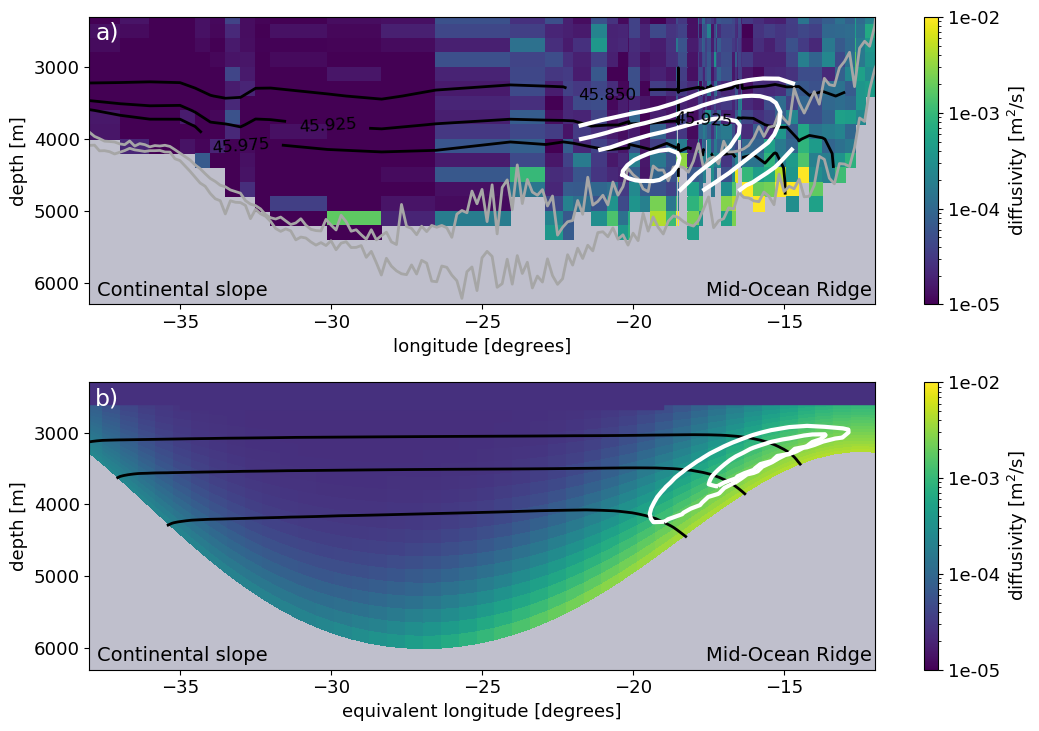

In [38]:
cmap = get_cmap("viridis")

norm=matplotlib.colors.LogNorm(vmin=1.e-5, vmax=1.e-2)
bounds = [1.e-5, 1.e-4, 1.e-3, 1.e-2]

gamma = 0.2;

figure(figsize=(11,7.5))
PyCall.PyDict(matplotlib."rcParams")["font.size"]=13;

subplot(2,1,1)
ax = gca()
ax.set_facecolor(topo_col)

Gamma = 0.2
pcolor(lon_2d,z_grid,Gamma*eps_2d./Nsq_2d,cmap=cmap,norm=norm)
cb = colorbar(ticks=bounds,label=L"diffusivity [m$^{2}$/s]", format="%.0e")

filepath = "../data/raw/Etopo/ETOPO1_Bed_g_gmt4.grd"

#ncinfo(filepath)
lon = ncread(filepath,"x");
lat = ncread(filepath,"y");
z = ncread(filepath,"z");

# CS = contour(lon_woce,-depth_woce,gamman_woce_sec',
#     levels=[28.1,28.16,28.2],colors="black",linestyles="solid")
CS = contour(lon_2d,z_grid,σ₄_2d,
     levels=[45.850,45.925,45.975],colors="black",linestyles="solid",linewidths=2.)
clabel(CS, inline=1, fontsize=12)

m,lat_idx = findmin(abs.(lat .+22.));
plot(track_lon_hi[1:10:end],track_mindep[1:10:end],lw=2.,color=(0.65,0.65,0.65))
plot(track_lon_hi[1:10:end],track_maxdep[1:10:end],lw=2.,color=(0.65,0.65,0.65))
xlim([-38,-12])
ylim([6300,2300])
ylabel("depth [m]")
xlabel("longitude [degrees]")

# streamlines from StLaurent 2001
xs = -[20.349123,20.149677,19.922495,19.761791,19.584452,19.340612,19.124458,18.913807,18.703146,18.525684,18.464598,18.525473,18.813591,19.146124,19.467598,19.733665,19.955395,20.188246,20.337975,20.349123]
zs = [4494.901,4544.6074,4572.258,4580.5815,4580.6357,4583.4688,4566.9863,4517.4053,4462.3086,4363.072,4261.0415,4192.071,4145.095,4161.542,4197.2983,4244.1045,4288.1655,4362.5625,4442.5010,4494.901]
plot(xs,zs,"w-",lw=3.)

zs = [4705.1025,4594.8643,4492.8867,4377.1543,4236.625,4101.588,3919.6428,3806.57,3748.6182,3709.8606,3715.2988,3734.5305,3797.7864,3894.0679,3940.8057,4015.0818,4114.1636,4147.157]
xs = -[18.431896,18.154665,17.921782,17.5725,17.14006,16.785213,16.49681,16.468962,16.574184,17.045197,17.300129,17.543995,18.131512,18.951828,19.439571,20.065893,20.747667,21.085762]
plot(xs,zs,"w-",lw=3.)

zs = [4702.5854,4606.1597,4468.404,4236.941,4046.8115,3933.7932,3782.1465,3622.1914,3495.2742,3440.0547,3401.3381,3395.7388,3401.175,3423.124,3453.349,3497.3682,3533.1365,3566.1724,3626.709,3690.0125,3731.268,3778.023,3811.0112,3846.7744,3877.0115,3907.2773,3940.2842,3965.0374,3998.0256]
xs = -[17.644947,17.295689,16.813375,16.109272,15.52714,15.321951,15.166591,15.122058,15.271531,15.459887,15.797894,16.069437,16.329912,16.706787,17.07813,17.438406,17.721087,17.920633,18.380684,18.813028,19.189926,19.622252,19.97697,20.276278,20.608826,20.847164,21.140924,21.368172,21.722893]
plot(xs,zs,"w-",lw=3.)

zs = [4703.972,4640.649,4602.129,4533.306,4469.991,4390.1514,4313.042,4145.0454,NaN,3224.5845,3158.2986,3155.383,3166.3271,3180.032,3212.979,3259.7122,3314.6912,3366.9363,3424.705,3501.723,3567.7068,3606.1692,3639.1094,3666.575,3696.7898,3735.242,3776.465,3809.4410]
xs = -[16.453444,16.248318,16.04322,15.799293,15.566455,15.300346,15.11737,14.745856,NaN,14.705923,15.1769,15.697832,15.958314,16.202173,16.606771,16.989218,17.44372,17.826174,18.16984,18.652079,19.167555,19.561075,19.98784,20.292677,20.619684,21.046457,21.423355,21.73374]
plot(xs,zs,"w-",lw=3.)

annotate(s="a)",xy=(0.0075,0.92),xycoords="axes fraction",fontsize=17,color="w")
annotate(s="Continental slope",xy=(0.01,0.03),xycoords="axes fraction",fontsize=14)
annotate(s="Mid-Ocean Ridge",xy=(0.785,0.03),xycoords="axes fraction",fontsize=14)

expname = "../pgcm/ridge-0.8_del-0.4"
include(string(expname,"/runs/equil/kernel.jl"))

## Model Parameters
r = 0.1; # friction coefficient
a = 0.2; # aspect ratio (?)

H = 4000.
L = 6000.e3
k = 5.e-2

nIter = 40000*50

# Plotting Parameters
lati = 150 # latitude of transect

subplot(2,1,2)
ax = gca()
ax.set_facecolor(topo_col)

m = load(string(expname,"/runs/equil")) # Model setup
s = load(string(expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

dxgrid = 2*pi*6371e3/360. *cos(2*pi*-24/360.)

reflon = 42.

pcolor(xc[2:end,lati,:]*L/dxgrid .-reflon,-(m.sf.*m.hc)[:,lati,:]*H .+Htop,(m.kfs.*ones(size(m.hc)))[:,lati,:]*kscale,
    cmap=cmap,norm=norm)
cb = colorbar(ticks=bounds,label=L"diffusivity [m$^{2}$/s]", format="%.0e")

contour(xc[:,lati,:]*L/dxgrid .-reflon,-(m.sc.*m.hc)[:,lati,:]*H .+Htop,s.bc[:,lati,:],
    levels=[-0.2,-0.14,-0.085],colors="black",linestyles="solid",linewidths=2.)

mask = ones(size(x_xz))
mask[(x_xz*L/dxgrid.-reflon).<-21.5] .= NaN

contour(x_xz*L/dxgrid .-reflon,-z_xz*H .+Htop,-psi_xz.*mask*Tscale,colors="w",linewidths=3.,levels=[0.25,0.5,0.75,1.0])
fill_between([-50,0],[2600,2600],[0,0],color=cmap(0.14))
fill_between([-35,-19],[2675,2675],[0,0],color=cmap(0.14))
ylabel("depth [m]")
xlabel("equivalent longitude [degrees]")
ylim([6300,2300])
xlim([-38,-12])
annotate(s="b)",xy=(0.0075,0.92),xycoords="axes fraction",fontsize=17,color="w")
annotate(s="Continental slope",xy=(0.01,0.03),xycoords="axes fraction",fontsize=14)
annotate(s="Mid-Ocean Ridge",xy=(0.785,0.03),xycoords="axes fraction",fontsize=14)
tight_layout()
savefig("../figures/motivation.png",dpi=dpi,bbox_inches="tight")